# Playbook

A simple notebook about producing time series out of the Star Citizen funding tracker spreadsheet, and extracting interesting insights.

In [1]:
%load_ext autoreload
%autoreload 2

## Data Extraction

In [2]:
import altair as alt
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
alt.renderers.enable('html')

RendererRegistry.enable('html')

In [4]:
from app.src.loading.loader import TransactionParser, CalendarEventParser, GameVersionParser
from app.src.loading.combined_signals import CompleteTimeSeries
from app.src.visuals import charts
from app.src.stats import correlations, observations

### Transactions

The transaction parser direclty fetches raw hourly transaction data from the public Google Drive.
Under the hood it corrects misformatted dates, checks for duplicates, cleans up the data, transforms it into a time series (with resampling at hourly level and interpolation, fixing periods where the data was measured daily only), and enriches the data with totals and time-based metrics post-aggregation at whichever frequency is needed ('D', 'W', 'ME', 'YE' being the most useful time resolutions).

In [5]:
transaction_parser = TransactionParser()

2025-01-27 17:39:36.561 | INFO     | app.src.loading.loader:load_data:37 - Loading data from https://docs.google.com/spreadsheets/d/1n96sotjICGR8pw7SL74KTwrCHO6hoqRuAc2Y_fbIJaA/gviz/tq?tqx=out:csv&sheet=Hourly%20Data%20Import
2025-01-27 17:39:40.908 | INFO     | app.src.loading.loader:load_data:39 - Data loaded successfully with shape (103127, 7)
103127it [00:02, 44634.68it/s]
2025-01-27 17:39:43.317 | SUCCESS  | app.src.loading.loader:parse_transactions:128 - Imported 103,127 hourly transactions
2025-01-27 17:39:43.474 | ERROR    | app.src.loading.loader:parse_dataframe:148 - datetime_utc=datetime.datetime(2024, 12, 6, 17, 0) total_pledge=0.0 delta_pledge=None total_citizens=5455992 delta_citizens=37 data_correction_total_pledge=None data_correction_total_citizen=None
2025-01-27 17:39:43.475 | ERROR    | app.src.loading.loader:parse_dataframe:148 - datetime_utc=datetime.datetime(2024, 12, 6, 18, 0) total_pledge=764032825.0 delta_pledge=None total_citizens=5456025 delta_citizens=33 dat

In [6]:
transaction_parser.main_statistics

2025-01-27 17:39:46.777 | INFO     | app.src.loading.time_series:get:167 - Providing time series at desired frequency (h) for caller: TransactionParser


{'time': {'now': datetime.datetime(2025, 1, 27, 22, 39, 47, 73875, tzinfo=datetime.timezone.utc),
  'last_updated': Timestamp('2025-01-27 21:00:00'),
  'time_since_measure': Timedelta('0 days 01:39:47.073875'),
  'year_completion_percentage': 0.07392197125256673},
 'pledges': {'total_historically': 780113671.0,
  'total_this_year': 6073668.0,
  'total_year_on_year': 4820303.0,
  'pct_change_year_on_year': 0.26001788684238325},
 'citizens': {'total_historically': 5517443.0,
  'total_this_year': 27477.0,
  'total_year_on_year': 50032.0,
  'pct_change_year_on_year': -0.4508114806523825}}

### Sales event annotations 

Manual annotations have been made to flag sales events and particuliar milestones. There is little consistency (no taxonomy for instance), but this contains critically important information to predict the data. 

In [7]:
calendar_event_parser = CalendarEventParser()

2025-01-27 17:39:49.589 | INFO     | app.src.loading.loader:load_data:37 - Loading data from https://docs.google.com/spreadsheets/d/1n96sotjICGR8pw7SL74KTwrCHO6hoqRuAc2Y_fbIJaA/gviz/tq?tqx=out:csv&sheet=Sales%20%26%20Comments
2025-01-27 17:39:50.153 | INFO     | app.src.loading.loader:load_data:39 - Data loaded successfully with shape (4482, 6)
2025-01-27 17:39:50.240 | INFO     | app.src.loading.loader:parse:294 - 4482 valid records.


### Production of time series

It is very easy with the `TransactionParser` to obtain time series at any desired frequency (up to the original resolution in hours). The underlying data has gaps (transactions were recorded daily at times) and corrupted date formats. This class resolves those issues, resamples and interpolates gaps, recomputes cumulative totals at the desired time resolution, and provide time-based indexes (day of year, day of week, month, quarter, etc.)

In [8]:
ts_daily = transaction_parser.get_time_series('D')
ts_weekly = transaction_parser.get_time_series('W')
ts_monthly = transaction_parser.get_time_series('ME')
print(f"{len(ts_weekly)} weeks and {len(ts_daily)} days")
ts_daily.head(15)

2025-01-27 17:39:56.745 | INFO     | app.src.loading.time_series:get:167 - Providing time series at desired frequency (D) for caller: TransactionParser
2025-01-27 17:39:56.779 | INFO     | app.src.loading.time_series:get:167 - Providing time series at desired frequency (W-SUN) for caller: TransactionParser
2025-01-27 17:39:56.799 | INFO     | app.src.loading.time_series:get:167 - Providing time series at desired frequency (ME) for caller: TransactionParser


638 weeks and 4459 days


delta_pledge  delta_citizens  total_pledge_in_year  \
datetime_utc                                                       
2012-11-13     3453012.000       48878.750           3453012.000   
2012-11-14      112706.250        1554.750           3565718.250   
2012-11-15      128694.250        1646.000           3694412.500   
2012-11-16      240527.750        3228.000           3934940.250   
2012-11-17      365400.750        4742.375           4300341.000   
2012-11-18      616699.000       14173.375           4917040.000   
2012-11-19     1337568.875        6813.750           6254608.875   
2012-11-20      128852.500       11209.375           6383461.375   
2012-11-21      126035.875        1418.875           6509497.250   
2012-11-22       82195.375        1321.750           6591692.625   
2012-11-23       76597.625         647.875           6668290.250   
2012-11-24       55632.125         647.125           6723922.375   
2012-11-25       65939.500         647.875           6789861.875   
2012-11-26       45372.750         655.125           6835234.625   
2012-11-27       20468.875         667.000           6855703.500   

              total_citizens_in_year  total_citizens  total_pledge  \
datetime_utc                                                         
2012-11-13                 48878.750       48878.750   3453012.000   
2012-11-14                 50433.500       50433.500   3565718.250   
2012-11-15                 52079.500       52079.500   3694412.500   
2012-11-16                 55307.500       55307.500   3934940.250   
2012-11-17                 60049.875       60049.875   4300341.000   
2012-11-18                 74223.250       74223.250   4917040.000   
2012-11-19                 81037.000       81037.000   6254608.875   
2012-11-20                 92246.375       92246.375   6383461.375   
2012-11-21                 93665.250       93665.250   6509497.250   
2012-11-22                 94987.000       94987.000   6591692.625   
2012-11-23                 95634.875       95634.875   6668290.250   
2012-11-24                 96282.000       96282.000   6723922.375   
2012-11-25                 96929.875       96929.875   6789861.875   
2012-11-26                 97585.000       97585.000   6835234.625   
2012-11-27                 98252.000       98252.000   6855703.500   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2012-11-13                      70.644442               70.644442   
2012-11-14                      70.701384               72.491558   
2012-11-15                      70.937941               78.186057   
2012-11-16                      71.146594               74.512934   
2012-11-17                      71.612822               77.050159   
2012-11-18                      66.246628               43.511090   
2012-11-19                      77.182137              196.304366   
2012-11-20                      69.200133               11.495066   
2012-11-21                      69.497463               88.828033   
2012-11-22                      69.395734               62.186779   
2012-11-23                      69.726554              118.229018   
2012-11-24                      69.835716               85.968128   
2012-11-25                      70.049217              101.778121   
2012-11-26                      70.043907               69.258157   
2012-11-27                      69.776732               30.687969   

              pledge_prior_30_periods  citizens_prior_30_periods  year  \
datetime_utc                                                             
2012-11-13                        NaN                        NaN  2012   
2012-11-14                3453012.000                  48878.750  2012   
2012-11-15                3565718.250                  50433.500  2012   
2012-11-16                3694412.500                  52079.500  2012   
2012-11-17                3934940.250           

In [9]:
charts.plot_line_chart(ts_weekly)

alt.VConcatChart(...)

In [10]:
charts.plot_line_chart(ts_daily)

alt.VConcatChart(...)

In [11]:
ts_monthly_sales_events = calendar_event_parser.get_time_series(freq='ME')
ts_weekly_sales_events = calendar_event_parser.get_time_series(freq='W')
ts_sales_events = calendar_event_parser.get_time_series(freq='D')

2025-01-16 09:36:28.645 | INFO     | app.src.loading.time_series:get:141 - Providing time series at desired frequency (ME)
2025-01-16 09:36:28.652 | INFO     | app.src.loading.time_series:get:141 - Providing time series at desired frequency (W-SUN)
2025-01-16 09:36:28.662 | INFO     | app.src.loading.time_series:get:141 - Providing time series at desired frequency (D)


In [12]:
charts.plot_line_chart(
    dataframe = ts_monthly_sales_events, 
    title = 'Mapping of sales days',
    first_line_settings = {'x': 'on_sale', 'type': 'Q', 'format': '.0f', 'title': 'Active sales days per month'},
    second_line_settings = None,
)

alt.VConcatChart(...)

### Fishing for simple findings

In [13]:
# best years of funding
ts_annual = transaction_parser.get_time_series('YE')
best_years = observations.records(ts_annual, metric='delta_pledge')
best_years

2025-01-16 09:36:28.719 | INFO     | app.src.loading.time_series:get:141 - Providing time series at desired frequency (YE)


In [10]:
# best_januaries
best_januaries = observations.records(ts_monthly.query('month==1'), metric='delta_pledge')
best_januaries

In [11]:
# let's find the seven best days in terms of pledge amounts
best_days =  observations.records(ts_daily, metric='delta_pledge', n=7)
best_days

In [16]:
# historical worst months in terms of influx of new citizens
worst_months = observations.records(ts_monthly.query('delta_pledge>0'), metric='delta_citizens', ascending=True)
worst_months

In [12]:
# how often have months been better than October '24? 
observations.precedence(ts_monthly, timestamp=pd.Timestamp(2024,10, 31))

KeyError: 'version_id'

In [18]:
# how often have October months been better than October '24? 
observations.precedence(ts_monthly.query('month==10'), timestamp=pd.Timestamp(2024,10, 31))

In [19]:
charts.plot_all_years(transaction_parser, metric='pledges')

2025-01-16 09:36:28.930 | INFO     | app.src.loading.time_series:get:141 - Providing time series at desired frequency (W-SUN)
2025-01-16 09:36:28.938 | INFO     | app.src.loading.time_series:get:141 - Providing time series at desired frequency (YE)


alt.HConcatChart(...)

In [20]:
charts.plot_all_years(transaction_parser, metric='citizens')

2025-01-16 09:36:29.007 | INFO     | app.src.loading.time_series:get:141 - Providing time series at desired frequency (W-SUN)
2025-01-16 09:36:29.016 | INFO     | app.src.loading.time_series:get:141 - Providing time series at desired frequency (YE)


alt.HConcatChart(...)

In [21]:
ts_daily.head()

delta_pledge  delta_citizens  total_citizens  total_pledge  \
datetime_utc                                                               
2012-11-13    3.457695e+06    48944.333333    48944.333333  3.457695e+06   
2012-11-14    1.128110e+05     1548.333333    50492.666667  3.570506e+06   
2012-11-15    1.332903e+05     1721.333333    52214.000000  3.703796e+06   
2012-11-16    2.456330e+05     3228.000000    55442.000000  3.949429e+06   
2012-11-17    3.712883e+05     5247.166667    60689.166667  4.320718e+06   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2012-11-13                      70.645461               70.645461   
2012-11-14                      70.713358               72.859634   
2012-11-15                      70.934928               77.434353   
2012-11-16                      71.235333               76.094486   
2012-11-17                      71.194216               70.759775   

              total_citizens_in_year  total_pledge_in_year  day_of_year  \
datetime_utc                                                              
2012-11-13              48944.333333          3.457695e+06          318   
2012-11-14              50492.666667          3.570506e+06          319   
2012-11-15              52214.000000          3.703796e+06          320   
2012-11-16              55442.000000          3.949429e+06          321   
2012-11-17              60689.166667          4.320718e+06          322   

              week_of_year  day_of_week  is_weekend  year  quarter  month  \
datetime_utc                                                                
2012-11-13              46            1           0  2012        4     11   
2012-11-14              46            2           0  2012        4     11   
2012-11-15              46            3           0  2012        4     11   
2012-11-16              46            4           0  2012        4     11   
2012-11-17              46            5           1  2012        4     11   

                       period  delta_pledge_prior_30_periods  \
datetime_utc                                                   
2012-11-13    Tue 13 Nov 2012                            NaN   
2012-11-14    Wed 14 Nov 2012                   3.457695e+06   
2012-11-15    Thu 15 Nov 2012                   3.570506e+06   
2012-11-16    Fri 16 Nov 2012                   3.703796e+06   
2012-11-17    Sat 17 Nov 2012                   3.949429e+06   

              delta_citizens_prior_30_periods  
datetime_utc                                   
2012-11-13                                NaN  
2012-11-14                       48944.333333  
2012-11-15                       50492.666667  
2012-11-16                       52214.000000  
2012-11-17                       55442.000000

In [11]:
charts.plot_transactions_years_to_date(ts_daily, metric='pledges')

alt.HConcatChart(...)

In [ ]:
charts.plot_transactions_years_to_date(ts_daily, metric='citizens') 

alt.HConcatChart(...)

In [32]:
charts.plot_current_vs_last_year(ts_daily, metric='pledges')

KeyError: "['version_id'] not in index"

In [25]:
charts.plot_current_vs_last_year(ts_daily, metric='citizens', date=pd.Timestamp(2024,12,31))

alt.Chart(...)

### Feature engineering

In [26]:
from typing import List
def look_at_recent_past_and_future(
    ts: pd.DataFrame, 
    past: int = 7,
    future: int = 7, 
    summables: List[str] = ['delta_pledge', 'delta_citizens'],
    ) -> pd.DataFrame:
    for s in summables:
        ts[f"{s}_past"] = ts[s].rolling(window=past, min_periods=1).sum()
        ts[f"{s}_future"] = ts[s].shift(-1)[::-1].rolling(window=future, min_periods=1).sum()[::-1]

    ts = ts.iloc[past:-future]
    return ts

In [27]:
ts_daily_extended = look_at_recent_past_and_future(ts_daily)
ts_daily_extended.head()

delta_pledge  delta_citizens  total_citizens  total_pledge  \
datetime_utc                                                                
2012-11-20    129014.333333    10743.166667    92305.500000  6.388972e+06   
2012-11-21    123964.166667     1418.833333    93724.333333  6.512936e+06   
2012-11-22     82083.833333     1289.666667    95014.000000  6.595020e+06   
2012-11-23     75512.500000      647.833333    95661.833333  6.670532e+06   
2012-11-24     56239.500000      647.166667    96309.000000  6.726772e+06   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2012-11-20                      69.215505               12.008967   
2012-11-21                      69.490342               87.370492   
2012-11-22                      69.411032               63.647325   
2012-11-23                      69.730342              116.561616   
2012-11-24                      69.845724               86.901107   

              total_citizens_in_year  total_pledge_in_year  day_of_year  \
datetime_utc                                                              
2012-11-20              92305.500000          6.388972e+06          325   
2012-11-21              93724.333333          6.512936e+06          326   
2012-11-22              95014.000000          6.595020e+06          327   
2012-11-23              95661.833333          6.670532e+06          328   
2012-11-24              96309.000000          6.726772e+06          329   

              week_of_year  ...  year  quarter  month           period  \
datetime_utc                ...                                          
2012-11-20              47  ...  2012        4     11  Tue 20 Nov 2012   
2012-11-21              47  ...  2012        4     11  Wed 21 Nov 2012   
2012-11-22              47  ...  2012        4     11  Thu 22 Nov 2012   
2012-11-23              47  ...  2012        4     11  Fri 23 Nov 2012   
2012-11-24              47  ...  2012        4     11  Sat 24 Nov 2012   

              delta_pledge_prior_30_periods delta_citizens_prior_30_periods  \
datetime_utc                                                                  
2012-11-20                     6.259958e+06                    81562.333333   
2012-11-21                     6.388972e+06                    92305.500000   
2012-11-22                     6.512936e+06                    93724.333333   
2012-11-23                     6.595020e+06                    95014.000000   
2012-11-24                     6.670532e+06                    95661.833333   

              delta_pledge_past  delta_pledge_future  delta_citizens_past  \
datetime_utc                                                                
2012-11-20         2.931277e+06        467332.500000         43361.166667   
2012-11-21         2.942430e+06        357024.666667         43231.666667   
2012-11-22         2.891223e+06        285663.166667         42800.000000   
2012-11-23         2.721103e+06        225809.000000         40219.833333   
2012-11-24         2.406054e+06        187683.000000         35619.833333   

              delta_citizens_future  
datetime_utc                         
2012-11-20              5961.166667  
2012-11-21              4851.833333  
2012-11-22              3677.666667  
2012-11-23              3244.166667  
2012-11-24              2842.833333  

[5 rows x 22 columns]

In [28]:
ts_daily_extended['delta_citizens_future'].describe()

count     4434.000000
mean      8541.626485
std       9321.977462
min        376.166667
25%       4058.250000
50%       5263.000000
75%       8950.750000
max      88175.000000
Name: delta_citizens_future, dtype: float64

In [29]:
correlations_over_time = correlations.compute_correlations_with_sliding_window(
    ts_daily_extended, window_size=60,
    x = 'delta_citizens', 
    y = 'delta_pledge', 
)

2025-01-16 09:36:29.276 | INFO     | app.src.stats.correlations:compute_correlations_with_sliding_window:21 - correlations - computing correlations of delta_citizens with delta_pledge for 4375 periods of size 60 (time resolution: D)
100%|██████████| 4375/4375 [00:02<00:00, 1895.05it/s]


In [30]:
correlations_over_time.head(10)

start_date   end_date               x             y         r         p-val  \
0 2012-11-20 2013-01-18  delta_citizens  delta_pledge  0.679929  2.308931e-09   
1 2012-11-21 2013-01-19  delta_citizens  delta_pledge  0.659846  9.784164e-09   
2 2012-11-22 2013-01-20  delta_citizens  delta_pledge  0.625846  8.933690e-08   
3 2012-11-23 2013-01-21  delta_citizens  delta_pledge  0.609836  2.314698e-07   
4 2012-11-24 2013-01-22  delta_citizens  delta_pledge  0.574043  1.624873e-06   
5 2012-11-25 2013-01-23  delta_citizens  delta_pledge  0.560702  3.171958e-06   
6 2012-11-26 2013-01-24  delta_citizens  delta_pledge  0.526740  1.536876e-05   
7 2012-11-27 2013-01-25  delta_citizens  delta_pledge  0.480603  1.016898e-04   
8 2012-11-28 2013-01-26  delta_citizens  delta_pledge  0.453673  2.721066e-04   
9 2012-11-29 2013-01-27  delta_citizens  delta_pledge  0.415165  9.722232e-04   

    n     power       avg_x         avg_y  
0  60  0.999993  419.083333  18862.486111  
1  60  0.999976  241.855556  16815.561111  
2  60  0.999855  219.988889  14864.041667  
3  60  0.999695  200.263889  13610.530556  
4  60  0.998688  191.230556  12469.627778  
5  60  0.997876  182.108333  11661.705556  
6  60  0.993664  172.816667  10695.172222  
7  60  0.978458  163.025000  10114.122222  
8  60  0.960886  155.188889   9937.913889  
9  60  0.919263  152.633333   9881.977778

In [31]:
charts.plot_line_chart(
    dataframe = correlations_over_time, 
    index = 'start_date', 
    title = 'Correlation between recent account creations and pledges over time',
    first_line_settings = {'x': 'r', 'type': 'Q', 'format': '.2f', 'title': 'Correlation coefficient'},
    second_line_settings = {'x': 'avg_x', 'type': 'Q', 'format': '$,.0f', 'title': 'Average daily pledge ($)'},
)

alt.VConcatChart(...)

In [32]:
charts.plot_line_chart(
    dataframe = ts_weekly, 
    title = 'Average pledge by backer',
    first_line_settings = {'x': 'cumulative_avg_pledge_total', 'type': 'Q', 'format': '$,.0f', 'title': '$ total / citizen total (cumulative)'},
    second_line_settings = {'x': 'local_avg_pledge_total', 'type': 'Q', 'format': '$,.0f', 'title': '$ added / citizen added (in period)'},
)

alt.VConcatChart(...)

### Vector Autoregressive Model

In [13]:
cts = CompleteTimeSeries()

2025-01-27 17:40:43.821 | INFO     | app.src.loading.loader:load_data:37 - Loading data from https://docs.google.com/spreadsheets/d/1n96sotjICGR8pw7SL74KTwrCHO6hoqRuAc2Y_fbIJaA/gviz/tq?tqx=out:csv&sheet=Hourly%20Data%20Import
2025-01-27 17:40:49.111 | INFO     | app.src.loading.loader:load_data:39 - Data loaded successfully with shape (103127, 7)
103127it [00:02, 44684.79it/s]
2025-01-27 17:40:51.422 | SUCCESS  | app.src.loading.loader:parse_transactions:128 - Imported 103,127 hourly transactions
2025-01-27 17:40:51.567 | ERROR    | app.src.loading.loader:parse_dataframe:148 - datetime_utc=datetime.datetime(2024, 12, 6, 17, 0) total_pledge=0.0 delta_pledge=None total_citizens=5455992 delta_citizens=37 data_correction_total_pledge=None data_correction_total_citizen=None
2025-01-27 17:40:51.567 | ERROR    | app.src.loading.loader:parse_dataframe:148 - datetime_utc=datetime.datetime(2024, 12, 6, 18, 0) total_pledge=764032825.0 delta_pledge=None total_citizens=5456025 delta_citizens=33 dat

In [14]:
cts.time_series.tail(10)

delta_pledge  delta_citizens  total_pledge_in_year  \
datetime_utc                                                       
2025-02-10        166891.0           738.0             6073668.0   
2025-02-11        166891.0           738.0             6073668.0   
2025-02-12        166891.0           738.0             6073668.0   
2025-02-13        166891.0           738.0             6073668.0   
2025-02-14        166891.0           738.0             6073668.0   
2025-02-15        166891.0           738.0             6073668.0   
2025-02-16        166891.0           738.0             6073668.0   
2025-02-17        166891.0           738.0             6073668.0   
2025-02-18        166891.0           738.0             6073668.0   
2025-02-19        166891.0           738.0             6073668.0   

              total_citizens_in_year  total_citizens  total_pledge  \
datetime_utc                                                         
2025-02-10                   27477.0       5517443.0   780113671.0   
2025-02-11                   27477.0       5517443.0   780113671.0   
2025-02-12                   27477.0       5517443.0   780113671.0   
2025-02-13                   27477.0       5517443.0   780113671.0   
2025-02-14                   27477.0       5517443.0   780113671.0   
2025-02-15                   27477.0       5517443.0   780113671.0   
2025-02-16                   27477.0       5517443.0   780113671.0   
2025-02-17                   27477.0       5517443.0   780113671.0   
2025-02-18                   27477.0       5517443.0   780113671.0   
2025-02-19                   27477.0       5517443.0   780113671.0   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2025-02-10                     141.390436              226.139566   
2025-02-11                     141.390436              226.139566   
2025-02-12                     141.390436              226.139566   
2025-02-13                     141.390436              226.139566   
2025-02-14                     141.390436              226.139566   
2025-02-15                     141.390436              226.139566   
2025-02-16                     141.390436              226.139566   
2025-02-17                     141.390436              226.139566   
2025-02-18                     141.390436              226.139566   
2025-02-19                     141.390436              226.139566   

              pledge_prior_30_periods  citizens_prior_30_periods  ...  \
datetime_utc                                                      ...   
2025-02-10                  7379941.0                    32564.0  ...   
2025-02-11                  7379941.0                    32564.0  ...   
2025-02-12                  7379941.0                    32564.0  ...   
2025-02-13                  7379941.0                    32564.0  ...   
2025-02-14                  7379941.0                    32564.0  ...   
2025-02-15                  7379941.0                    32564.0  ...   
2025-02-16                  7379941.0                    32564.0  ...   
2025-02-17                  7379941.0                    32564.0  ...   
2025-02-18                  7379941.0                    32564.0  ...   
2025-02-19                  7379941.0                    32564.0  ...   

              week_of_year  day_of_year  day_of_week  is_weekend  \
datetime_utc                                                       
2025-02-10               5         27.0          0.0         0.0   
2025-02-11               5         27.0          0.0         0.0   
2025-02-12               5         27.0          0.0         0.0   
2025-02-13               5         27.0          0.0         0.0   
2025-02-14               5         27.0          0.0         0.0   
2025-02-15               5         27.0          0.0         0.0   
2025-02-16               5         27.0          0.0         0.0   
2025-02-17               5         27.

In [15]:
cts.transaction_parser.main_statistics

2025-01-27 17:41:00.095 | INFO     | app.src.loading.time_series:get:167 - Providing time series at desired frequency (h) for caller: TransactionParser


{'time': {'now': datetime.datetime(2025, 1, 27, 22, 41, 0, 385341, tzinfo=datetime.timezone.utc),
  'last_updated': Timestamp('2025-01-27 21:00:00'),
  'time_since_measure': Timedelta('0 days 01:41:00.385341'),
  'year_completion_percentage': 0.07392197125256673},
 'pledges': {'total_historically': 780113671.0,
  'total_this_year': 6073668.0,
  'total_year_on_year': 4820303.0,
  'pct_change_year_on_year': 0.26001788684238325},
 'citizens': {'total_historically': 5517443.0,
  'total_this_year': 27477.0,
  'total_year_on_year': 50032.0,
  'pct_change_year_on_year': -0.4508114806523825}}

In [16]:
cts.time_series.head()

delta_pledge  delta_citizens  total_pledge_in_year  \
datetime_utc                                                       
2012-11-13      3453012.00       48878.750            3453012.00   
2012-11-14       112706.25        1554.750            3565718.25   
2012-11-15       128694.25        1646.000            3694412.50   
2012-11-16       240527.75        3228.000            3934940.25   
2012-11-17       365400.75        4742.375            4300341.00   

              total_citizens_in_year  total_citizens  total_pledge  \
datetime_utc                                                         
2012-11-13                 48878.750       48878.750    3453012.00   
2012-11-14                 50433.500       50433.500    3565718.25   
2012-11-15                 52079.500       52079.500    3694412.50   
2012-11-16                 55307.500       55307.500    3934940.25   
2012-11-17                 60049.875       60049.875    4300341.00   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2012-11-13                      70.644442               70.644442   
2012-11-14                      70.701384               72.491558   
2012-11-15                      70.937941               78.186057   
2012-11-16                      71.146594               74.512934   
2012-11-17                      71.612822               77.050159   

              pledge_prior_30_periods  citizens_prior_30_periods  ...  \
datetime_utc                                                      ...   
2012-11-13                        NaN                        NaN  ...   
2012-11-14                 3453012.00                   48878.75  ...   
2012-11-15                 3565718.25                   50433.50  ...   
2012-11-16                 3694412.50                   52079.50  ...   
2012-11-17                 3934940.25                   55307.50  ...   

              week_of_year  day_of_year  day_of_week  is_weekend  \
datetime_utc                                                       
2012-11-13              46        318.0          1.0         0.0   
2012-11-14              46        319.0          2.0         0.0   
2012-11-15              46        320.0          3.0         0.0   
2012-11-16              46        321.0          4.0         0.0   
2012-11-17              46        322.0          5.0         1.0   

                       period  on_sale  on_sale_prior_30_periods  \
datetime_utc                                                       
2012-11-13    Tue 13 Nov 2012      0.0                       NaN   
2012-11-14    Wed 14 Nov 2012      0.0                       0.0   
2012-11-15    Thu 15 Nov 2012      0.0                       0.0   
2012-11-16    Fri 16 Nov 2012      0.0                       0.0   
2012-11-17    Sat 17 Nov 2012      0.0                       0.0   

             days_since_current_patch_launch  patches_during_period  \
datetime_utc                                                          
2012-11-13                               1.0                    1.0   
2012-11-14                               2.0                    1.0   
2012-11-15                               3.0                    1.0   
2012-11-16                               4.0                    1.0   
2012-11-17                               5.0                    1.0   

               version_id  
datetime_utc               
2012-11-13    Pre-Release  
2012-11-14    Pre-Release  
2012-11-15    Pre-Release  
2012-11-16    Pre-Release  
2012-11-17    Pre-Release  

[5 rows x 23 columns]

In [ ]:
engo = ['delta_pledge', 'delta_citizens']
exo = ['on_sale', 'days_since_patch_launch', ]

In [ ]:
data_var_weekly = ts_weekly.join(ts_weekly_sales_events[['on_sale']], how='left')
data_var_weekly.head()

In [ ]:
max_lag: int = 3

model = VAR(endog=data_var_weekly[['delta_pledge', 'total_citizens',]], exog=data_var_weekly[['delta_citizens', 'on_sale']], dates=ts_daily.index, freq='D')
model_fit = model.fit(maxlags=max_lag, ic='aic')
print(model_fit.summary())

These results provide a detailed view of how delta_pledge is influenced by its own past values, the past values of total_citizens, and the current changes in delta_citizens.

an incremental increase in `delta_citizens` is estimated to contribute $22.55 in incremental sales (`delta_pledge`), consistent with a 50% conversion rate and entry purchase of a $45 starter pack.

we note also the autocorrelation of `delta_pledge` at lag 1 (0.62)

### Granger Causality

In [667]:
gg = grangercausalitytests(cts.time_series[['delta_pledge', 'delta_citizens']], maxlag=[1, 5, 15])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.0855 , p=0.0002  , df_denom=4446, df_num=1
ssr based chi2 test:   chi2=14.0950 , p=0.0002  , df=1
likelihood ratio test: chi2=14.0727 , p=0.0002  , df=1
parameter F test:         F=14.0855 , p=0.0002  , df_denom=4446, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=38.0215 , p=0.0000  , df_denom=4434, df_num=5
ssr based chi2 test:   chi2=190.5794, p=0.0000  , df=5
likelihood ratio test: chi2=186.6070, p=0.0000  , df=5
parameter F test:         F=38.0215 , p=0.0000  , df_denom=4434, df_num=5

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=15.8012 , p=0.0000  , df_denom=4404, df_num=15
ssr based chi2 test:   chi2=238.6858, p=0.0000  , df=15
likelihood ratio test: chi2=232.4845, p=0.0000  , df=15
parameter F test:         F=15.8012 , p=0.0000  , df_denom=4404, df_num=15


This indicates that the null hypothesis (that delta_citizens does not Granger-cause delta_pledge) can be rejected at conventional significance levels. In other words, there is strong evidence that delta_citizens Granger-causes delta_pledge.

### Prophet Modelling

In [668]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [672]:
df = cts.time_series.reset_index().rename(columns={'datetime_utc': 'ds', 'delta_pledge': 'y'})[['ds', 'y', 'delta_citizens', 'citizens_prior_30_periods']].iloc[:-1]
df.head()

ds           y  delta_citizens  citizens_prior_30_periods
0 2012-11-13  3453012.00       48878.750                        NaN
1 2012-11-14   112706.25        1554.750                   48878.75
2 2012-11-15   128694.25        1646.000                   50433.50
3 2012-11-16   240527.75        3228.000                   52079.50
4 2012-11-17   365400.75        4742.375                   55307.50

In [673]:
events = cts.time_series.reset_index().rename(columns={'datetime_utc': 'ds', 'on_sale': 'holiday'})[['ds', 'holiday']].query('holiday>0')
events[['lower_window', 'upper_window']] = 0
events['holiday'] = 'sale'
events.head(1000)

ds holiday  lower_window  upper_window
331  2013-10-10    sale             0             0
332  2013-10-11    sale             0             0
333  2013-10-12    sale             0             0
334  2013-10-13    sale             0             0
335  2013-10-14    sale             0             0
...         ...     ...           ...           ...
4421 2024-12-21    sale             0             0
4422 2024-12-22    sale             0             0
4423 2024-12-23    sale             0             0
4424 2024-12-24    sale             0             0
4425 2024-12-25    sale             0             0

[585 rows x 4 columns]

In [ ]:
df.dtypes

In [674]:
m = Prophet(holidays=events, seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')

In [675]:
m.fit(df)

14:42:15 - cmdstanpy - INFO - Chain [1] start processing
14:42:16 - cmdstanpy - INFO - Chain [1] done processing


https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

In [676]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '90 days')

  0%|          | 0/21 [00:00<?, ?it/s]

14:42:21 - cmdstanpy - INFO - Chain [1] start processing
14:42:21 - cmdstanpy - INFO - Chain [1] done processing
14:42:21 - cmdstanpy - INFO - Chain [1] start processing
14:42:21 - cmdstanpy - INFO - Chain [1] done processing
14:42:22 - cmdstanpy - INFO - Chain [1] start processing
14:42:22 - cmdstanpy - INFO - Chain [1] done processing
14:42:22 - cmdstanpy - INFO - Chain [1] start processing
14:42:22 - cmdstanpy - INFO - Chain [1] done processing
14:42:22 - cmdstanpy - INFO - Chain [1] start processing
14:42:22 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:23 - cmdstanpy - INFO - Chain [1] done processing
14:42:23 - cmdstanpy - INFO - Chain [1] start processing
14:42:24 - cmdstanpy - INFO - Chain [1]

In [677]:
df_cv.head()

ds          yhat     yhat_lower     yhat_upper        y     cutoff
0 2014-12-12  -2487.571232 -160612.990738  161207.224078  49894.0 2014-12-11
1 2014-12-13  10749.340207 -155540.901362  191396.410412  70233.0 2014-12-11
2 2014-12-14   9109.420038 -170158.665278  191932.251202  43504.0 2014-12-11
3 2014-12-15  22821.505353 -157091.824978  198780.209915  35423.0 2014-12-11
4 2014-12-16  44635.106563 -133292.735598  221445.130620  29661.0 2014-12-11

In [678]:
df_p = performance_metrics(df_cv)
df_p.head()


horizon           mse           rmse            mae      mape     mdape  \
0  9 days  4.821964e+10  219589.706080  129015.246576  0.933677  0.639648   
1 10 days  4.482421e+10  211717.288015  130551.988102  0.969479  0.639648   
2 11 days  5.172425e+10  227429.669290  140698.385287  1.050446  0.660356   
3 12 days  5.503408e+10  234593.439368  147981.903810  1.076028  0.662053   
4 13 days  6.312477e+10  251246.436365  158424.422377  1.097670  0.677313   

      smape  coverage  
0  0.804893  0.820106  
1  0.808554  0.804233  
2  0.826876  0.783069  
3  0.833684  0.761905  
4  0.839967  0.735450

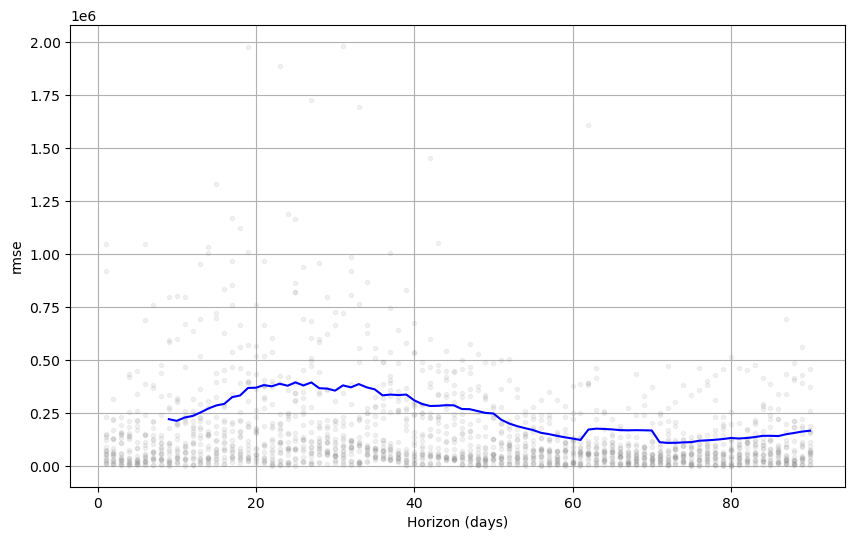

In [679]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')


In [45]:
future = m.make_future_dataframe(periods=150)

In [ ]:
future.tail(15)

In [ ]:
forecast = m.predict(future)
m.plot(forecast)

### Playground

In [33]:
transaction_parser.time_series_constructor.deepest_time_series.tail()

total_pledge  total_citizens  delta_citizens  \
datetime_utc                                                        
2025-01-16 09:00:00   777666461.0       5507725.0            25.0   
2025-01-16 10:00:00   777672068.0       5507751.0            26.0   
2025-01-16 11:00:00   777675468.0       5507788.0            37.0   
2025-01-16 12:00:00   777679013.0       5507820.0            32.0   
2025-01-16 13:00:00   777684144.0       5507850.0            30.0   

                     delta_pledge  cumulative_avg_pledge_total  \
datetime_utc                                                     
2025-01-16 09:00:00        5535.0                   141.195586   
2025-01-16 10:00:00        5607.0                   141.195938   
2025-01-16 11:00:00        3400.0                   141.195607   
2025-01-16 12:00:00        3545.0                   141.195430   
2025-01-16 13:00:00        5131.0                   141.195592   

                     local_avg_pledge_total  total_citizens_in_year  \
datetime_utc                                                          
2025-01-16 09:00:00              221.400000                 17759.0   
2025-01-16 10:00:00              215.653846                 17785.0   
2025-01-16 11:00:00               91.891892                 17822.0   
2025-01-16 12:00:00              110.781250                 17854.0   
2025-01-16 13:00:00              171.033333                 17884.0   

                     total_pledge_in_year  hour  day_of_year  week_of_year  \
datetime_utc                                                                 
2025-01-16 09:00:00             3626458.0     9           16             3   
2025-01-16 10:00:00             3632065.0    10           16             3   
2025-01-16 11:00:00             3635465.0    11           16             3   
2025-01-16 12:00:00             3639010.0    12           16             3   
2025-01-16 13:00:00             3644141.0    13           16             3   

                     day_of_week  is_weekend  year  quarter  month  \
datetime_utc                                                         
2025-01-16 09:00:00            3           0  2025        1      1   
2025-01-16 10:00:00            3           0  2025        1      1   
2025-01-16 11:00:00            3           0  2025        1      1   
2025-01-16 12:00:00            3           0  2025        1      1   
2025-01-16 13:00:00            3           0  2025        1      1   

                                  period  delta_pledge_prior_30_periods  \
datetime_utc                                                              
2025-01-16 09:00:00  2025-01-16 09:00:00                       213292.0   
2025-01-16 10:00:00  2025-01-16 10:00:00                       210269.0   
2025-01-16 11:00:00  2025-01-16 11:00:00                       210698.0   
2025-01-16 12:00:00  2025-01-16 12:00:00                       207170.0   
2025-01-16 13:00:00  2025-01-16 13:00:00                       204865.0   

                     delta_citizens_prior_30_periods  
datetime_utc                                          
2025-01-16 09:00:00                            823.0  
2025-01-16 10:00:00                            824.0  
2025-01-16 11:00:00                            824.0  
2025-01-16 12:00:00                            837.0  
2025-01-16 13:00:00                            847.0

In [73]:
time_series = transaction_parser.time_series_constructor.deepest_time_series

In [74]:
time_series.tail()

total_pledge  total_citizens  delta_citizens  \
datetime_utc                                                        
2025-01-16 13:00:00   777684144.0       5507850.0            30.0   
2025-01-16 14:00:00   777688498.0       5507890.0            40.0   
2025-01-16 15:00:00   777694176.0       5507935.0            45.0   
2025-01-16 16:00:00   777701244.0       5507977.0            42.0   
2025-01-16 17:00:00   777708087.0       5508013.0            36.0   

                     delta_pledge  
datetime_utc                       
2025-01-16 13:00:00        5131.0  
2025-01-16 14:00:00        4354.0  
2025-01-16 15:00:00        5678.0  
2025-01-16 16:00:00        7068.0  
2025-01-16 17:00:00        6843.0

In [75]:
transaction_parser.time_series_constructor.get('D').tail()

2025-01-16 13:18:00.984 | INFO     | app.src.loading.time_series:get:144 - Providing time series at desired frequency (D)


delta_pledge  delta_citizens  total_citizens  total_pledge  \
datetime_utc                                                               
2025-01-12        218993.0          1088.0       5505389.0   777081141.0   
2025-01-13        180947.0           757.0       5506146.0   777262088.0   
2025-01-14        170946.0           675.0       5506821.0   777433034.0   
2025-01-15        168735.0           655.0       5507476.0   777601769.0   
2025-01-16        106318.0           537.0       5508013.0   777708087.0   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2025-01-12                     141.149180              201.280331   
2025-01-13                     141.162637              239.031704   
2025-01-14                     141.176376              253.253333   
2025-01-15                     141.190224              257.610687   
2025-01-16                     141.195761              197.985102   

              total_citizens_in_year  total_pledge_in_year  day_of_year  \
datetime_utc                                                              
2025-01-12                   15371.0             3024222.0           12   
2025-01-13                   16128.0             3205169.0           13   
2025-01-14                   16803.0             3376115.0           14   
2025-01-15                   17458.0             3544850.0           15   
2025-01-16                   17995.0             3651168.0           16   

              week_of_year  day_of_week  is_weekend  year  quarter  month  \
datetime_utc                                                                
2025-01-12               2            6           1  2025        1      1   
2025-01-13               3            0           0  2025        1      1   
2025-01-14               3            1           0  2025        1      1   
2025-01-15               3            2           0  2025        1      1   
2025-01-16               3            3           0  2025        1      1   

                       period  delta_pledge_prior_30_periods  \
datetime_utc                                                   
2025-01-12    Sun 12 Jan 2025                     11272242.0   
2025-01-13    Mon 13 Jan 2025                     11262932.0   
2025-01-14    Tue 14 Jan 2025                     11213443.0   
2025-01-15    Wed 15 Jan 2025                     11185130.0   
2025-01-16    Thu 16 Jan 2025                     11197284.0   

              delta_citizens_prior_30_periods  
datetime_utc                                   
2025-01-12                            40930.0  
2025-01-13                            40821.0  
2025-01-14                            40314.0  
2025-01-15                            39715.0  
2025-01-16                            39422.0

In [17]:
time_series.groupby(time_series.index.year)['delta_pledge'].cumsum().tail(15)

NameError: name 'time_series' is not defined

In [77]:
time_series[time_series.index.year==2025][['delta_pledge']].resample('D', label='left', closed='right').sum().cumsum()

delta_pledge
datetime_utc              
2024-12-31         16916.0
2025-01-01        328813.0
2025-01-02        624636.0
2025-01-03        942583.0
2025-01-04       1252689.0
2025-01-05       1543066.0
2025-01-06       1799572.0
2025-01-07       1990814.0
2025-01-08       2176579.0
2025-01-09       2362416.0
2025-01-10       2574894.0
2025-01-11       2822145.0
2025-01-12       3041138.0
2025-01-13       3222085.0
2025-01-14       3393031.0
2025-01-15       3561766.0
2025-01-16       3668084.0

In [80]:
ts_daily.groupby(ts_daily.index.year)['delta_pledge'].cumsum()

datetime_utc
2012-11-13    3.457695e+06
2012-11-14    3.570506e+06
2012-11-15    3.703796e+06
2012-11-16    3.949429e+06
2012-11-17    4.320718e+06
                  ...     
2025-01-12    3.024222e+06
2025-01-13    3.205169e+06
2025-01-14    3.376115e+06
2025-01-15    3.544850e+06
2025-01-16    3.651168e+06
Freq: D, Name: delta_pledge, Length: 4448, dtype: float64

In [81]:
time_series.groupby(time_series.index.year)['delta_pledge'].cumsum().tail(15)

datetime_utc
2025-01-16 03:00:00    3590766.0
2025-01-16 04:00:00    3597378.0
2025-01-16 05:00:00    3604272.0
2025-01-16 06:00:00    3610369.0
2025-01-16 07:00:00    3615188.0
2025-01-16 08:00:00    3620923.0
2025-01-16 09:00:00    3626458.0
2025-01-16 10:00:00    3632065.0
2025-01-16 11:00:00    3635465.0
2025-01-16 12:00:00    3639010.0
2025-01-16 13:00:00    3644141.0
2025-01-16 14:00:00    3648495.0
2025-01-16 15:00:00    3654173.0
2025-01-16 16:00:00    3661241.0
2025-01-16 17:00:00    3668084.0
Freq: h, Name: delta_pledge, dtype: float64

In [82]:
ts_daily[(ts_daily.index.year==2025)]['delta_pledge'].sum()

3651168.0

In [88]:
ts_daily[ts_daily.index.year==2025]['total_pledge'].max() - ts_daily[(ts_daily.index.year==2024) & (ts_daily.index.dayofweek==364)]['total_pledge'].min()

nan

In [41]:
ts_daily.tail(5)

delta_pledge  delta_citizens  total_citizens  total_pledge  \
datetime_utc                                                               
2025-01-12        218993.0          1088.0       5505389.0   777081141.0   
2025-01-13        180947.0           757.0       5506146.0   777262088.0   
2025-01-14        170946.0           675.0       5506821.0   777433034.0   
2025-01-15        168735.0           655.0       5507476.0   777601769.0   
2025-01-16         82375.0           374.0       5507850.0   777684144.0   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2025-01-12                     141.149180              201.280331   
2025-01-13                     141.162637              239.031704   
2025-01-14                     141.176376              253.253333   
2025-01-15                     141.190224              257.610687   
2025-01-16                     141.195592              220.254011   

              total_citizens_in_year  total_pledge_in_year  day_of_year  \
datetime_utc                                                              
2025-01-12                   15371.0             3024222.0           12   
2025-01-13                   16128.0             3205169.0           13   
2025-01-14                   16803.0             3376115.0           14   
2025-01-15                   17458.0             3544850.0           15   
2025-01-16                   17832.0             3627225.0           16   

              week_of_year  ...  year  quarter  month           period  \
datetime_utc                ...                                          
2025-01-12               2  ...  2025        1      1  Sun 12 Jan 2025   
2025-01-13               3  ...  2025        1      1  Mon 13 Jan 2025   
2025-01-14               3  ...  2025        1      1  Tue 14 Jan 2025   
2025-01-15               3  ...  2025        1      1  Wed 15 Jan 2025   
2025-01-16               3  ...  2025        1      1  Thu 16 Jan 2025   

              delta_pledge_prior_30_periods delta_citizens_prior_30_periods  \
datetime_utc                                                                  
2025-01-12                       11272242.0                         40930.0   
2025-01-13                       11262932.0                         40821.0   
2025-01-14                       11213443.0                         40314.0   
2025-01-15                       11185130.0                         39715.0   
2025-01-16                       11197284.0                         39422.0   

              delta_pledge_past  delta_pledge_future  delta_citizens_past  \
datetime_utc                                                                
2025-01-12            1498072.0             603003.0               7405.0   
2025-01-13            1422513.0             422056.0               6504.0   
2025-01-14            1402217.0             251110.0               6341.0   
2025-01-15            1385187.0              82375.0               6066.0   
2025-01-16            1281725.0                  NaN               5607.0   

              delta_citizens_future  
datetime_utc                         
2025-01-12                   2461.0  
2025-01-13                   1704.0  
2025-01-14                   1029.0  
2025-01-15                    374.0  
2025-01-16                      NaN  

[5 rows x 22 columns]

In [179]:
hourly = transaction_parser.get_time_series('h')
target = hourly['total_pledge_in_year'].iloc[-1]
output_2 = transaction_parser.get_time_series('D')
print(f"${target:,.0f}")

2025-01-16 13:48:41.172 | INFO     | app.src.loading.time_series:get:144 - Providing time series at desired frequency (h)
2025-01-16 13:48:41.447 | INFO     | app.src.loading.time_series:get:144 - Providing time series at desired frequency (D)


$3,668,084


In [193]:
self = transaction_parser.time_series_constructor
freq='W-SUN'
time_series = self.deepest_time_series[self.summables].resample(freq, ).sum() #label='left', closed='right',


In [194]:
output = (time_series
        .pipe(self.add_totals)
        .pipe(self.add_averages)
        .pipe(self.add_in_year_totals)
        .pipe(self.add_time_metrics)
        .pipe(self.add_rolling_totals, last_periods=30))

sum_from_deltas = output[output.index.year==2025]['delta_pledge'].sum()
print(f"sum from deltas\t${sum_from_deltas:,.0f}")
print(f"in-year value\t${output_2[output_2.index.year==2025]['total_pledge_in_year'].max():,.0f}")

sum from deltas	$4,354,017
in-year value	$3,668,084


In [195]:
output[output.index.year==2025]['delta_pledge'].sum() == target, output[output.index.year==2025]['total_pledge_in_year'].max() == target

(False, False)

In [196]:
output.tail(5)

delta_pledge  delta_citizens  total_citizens  total_pledge  \
datetime_utc                                                               
2024-12-22       4082496.0          8841.0       5475905.0   770320735.0   
2024-12-29       3033335.0         11448.0       5487353.0   773354070.0   
2025-01-05       2217671.0         10578.0       5497931.0   775571741.0   
2025-01-12       1498711.0          7417.0       5505348.0   777070452.0   
2025-01-19        637635.0          2665.0       5508013.0   777708087.0   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2024-12-22                     140.674598              461.768578   
2024-12-29                     140.933902              264.966370   
2025-01-05                     141.066110              209.649367   
2025-01-12                     141.148289              202.064312   
2025-01-19                     141.195761              239.262664   

              total_citizens_in_year  total_pledge_in_year  day_of_year  \
datetime_utc                                                              
2024-12-22                  471479.0           112908130.0          357   
2024-12-29                  482927.0           115941465.0          364   
2025-01-05                   10578.0             2217671.0            5   
2025-01-12                   17995.0             3716382.0           12   
2025-01-19                   20660.0             4354017.0           19   

              week_of_year  day_of_week  is_weekend  year  quarter  month  \
datetime_utc                                                                
2024-12-22              51            6           1  2024        4     12   
2024-12-29              52            6           1  2024        4     12   
2025-01-05               1            6           1  2025        1      1   
2025-01-12               2            6           1  2025        1      1   
2025-01-19               3            6           1  2025        1      1   

                period  delta_pledge_prior_30_periods  \
datetime_utc                                            
2024-12-22    2024 W51                     78044722.0   
2024-12-29    2024 W52                     71269421.0   
2025-01-05     2025 W1                     68106548.0   
2025-01-12     2025 W2                     68649915.0   
2025-01-19     2025 W3                     67641486.0   

              delta_citizens_prior_30_periods  
datetime_utc                                   
2024-12-22                           269881.0  
2024-12-29                           240174.0  
2025-01-05                           239653.0  
2025-01-12                           245044.0  
2025-01-19                           246918.0

In [116]:
output_2 = transaction_parser.get_time_series('D')


2025-01-16 13:30:14.771 | INFO     | app.src.loading.time_series:get:144 - Providing time series at desired frequency (D)


$3,651,168


In [117]:
output_2[output_2.index.year==2025]['total_pledge_in_year'].max() == target

False

In [203]:
ttp = TransactionParser()

2025-01-16 14:04:31.361 | INFO     | app.src.loading.loader:load_data:35 - Loading data from https://docs.google.com/spreadsheets/d/1n96sotjICGR8pw7SL74KTwrCHO6hoqRuAc2Y_fbIJaA/gviz/tq?tqx=out:csv&sheet=Hourly%20Data%20Import
2025-01-16 14:04:37.222 | INFO     | app.src.loading.loader:load_data:37 - Data loaded successfully with shape (102860, 7)
102860it [00:02, 45380.95it/s]
2025-01-16 14:04:39.493 | SUCCESS  | app.src.loading.loader:parse_transactions:105 - Imported 102,860 hourly transactions
2025-01-16 14:04:39.640 | ERROR    | app.src.loading.loader:parse_dataframe:125 - datetime_utc=datetime.datetime(2024, 12, 6, 17, 0) total_pledge=0.0 delta_pledge=None total_citizens=5455992 delta_citizens=37 data_correction_total_pledge=None data_correction_total_citizen=None
2025-01-16 14:04:39.641 | ERROR    | app.src.loading.loader:parse_dataframe:125 - datetime_utc=datetime.datetime(2024, 12, 6, 18, 0) total_pledge=764032825.0 delta_pledge=None total_citizens=5456025 delta_citizens=33 dat

In [204]:
ttp.time_series_constructor.deepest_time_series

total_pledge  total_citizens  delta_citizens  \
datetime_utc                                                        
2012-11-13 20:00:00     3438963.0    4.868200e+04    48682.000000   
2012-11-13 21:00:00     3443646.0    4.874758e+04       65.583333   
2012-11-13 22:00:00     3448329.0    4.881317e+04       65.583333   
2012-11-13 23:00:00     3453012.0    4.887875e+04       65.583333   
2012-11-14 00:00:00     3457695.0    4.894433e+04       65.583333   
...                           ...             ...             ...   
2025-01-16 14:00:00   777688498.0    5.507890e+06       40.000000   
2025-01-16 15:00:00   777694176.0    5.507935e+06       45.000000   
2025-01-16 16:00:00   777701244.0    5.507977e+06       42.000000   
2025-01-16 17:00:00   777708087.0    5.508013e+06       36.000000   
2025-01-16 18:00:00   777715702.0    5.508054e+06       41.000000   

                     delta_pledge  total_citizens_in_year  \
datetime_utc                                                
2012-11-13 20:00:00     3438963.0            48682.000000   
2012-11-13 21:00:00        4683.0            48747.583333   
2012-11-13 22:00:00        4683.0            48813.166667   
2012-11-13 23:00:00        4683.0            48878.750000   
2012-11-14 00:00:00        4683.0            48944.333333   
...                           ...                     ...   
2025-01-16 14:00:00        4354.0            17924.000000   
2025-01-16 15:00:00        5678.0            17969.000000   
2025-01-16 16:00:00        7068.0            18011.000000   
2025-01-16 17:00:00        6843.0            18047.000000   
2025-01-16 18:00:00        7615.0            18088.000000   

                     total_pledge_in_year  
datetime_utc                               
2012-11-13 20:00:00             3438963.0  
2012-11-13 21:00:00             3443646.0  
2012-11-13 22:00:00             3448329.0  
2012-11-13 23:00:00             3453012.0  
2012-11-14 00:00:00             3457695.0  
...                                   ...  
2025-01-16 14:00:00             3648495.0  
2025-01-16 15:00:00             3654173.0  
2025-01-16 16:00:00             3661241.0  
2025-01-16 17:00:00             3668084.0  
2025-01-16 18:00:00             3675699.0  

[106727 rows x 6 columns]

In [18]:
gv = GameVersionParser()

2025-01-27 17:41:41.571 | INFO     | app.src.loading.loader:load_data:37 - Loading data from https://docs.google.com/spreadsheets/d/1n96sotjICGR8pw7SL74KTwrCHO6hoqRuAc2Y_fbIJaA/gviz/tq?tqx=out:csv&sheet=Gameversion
2025-01-27 17:41:41.933 | INFO     | app.src.loading.loader:load_data:39 - Data loaded successfully with shape (135, 4)
2025-01-27 17:41:41.947 | INFO     | app.src.loading.loader:parse:410 - 123 valid game-version records.


In [19]:
gv.version_patch_count_map

{1: 'Pre-Release',
 2: 'Hangar Module',
 3: 'Patch 1',
 4: 'Patch 2',
 5: 'Patch 3',
 6: 'Patch 4',
 7: 'Patch 5',
 8: 'Patch 6',
 9: 'Patch 7',
 10: 'Patch 8',
 11: 'Patch 9',
 12: 'Patch 10',
 13: 'Patch 11.1',
 14: 'Patch 11.2',
 15: 'Patch V0.8',
 16: 'Patch V0.8.1',
 17: 'Patch V0.8.2',
 18: 'Patch V0.8.3',
 19: 'Patch V0.8.4',
 20: 'Patch V0.8.5',
 21: 'Patch V0.9',
 27: 'Patch V0.9.2',
 30: 'Patch V1.0.0',
 31: 'Patch V1.0.1',
 32: 'Patch V1.0.1a',
 36: 'Alpha 1.1.1',
 37: 'Alpha 1.1.2',
 38: 'Alpha 1.1.3',
 39: 'Alpha 1.1.4',
 40: 'Alpha 1.1.5',
 42: 'Alpha 1.1.6',
 43: 'Alpha 1.1.6a',
 44: 'Alpha 1.2.0',
 45: 'Alpha 1.3.0',
 46: 'Alpha 2.0.0',
 47: 'Alpha 2.1.0',
 48: 'Alpha 2.1.1',
 49: 'Alpha 2.1.2',
 50: 'Alpha 2.2.0',
 51: 'Alpha 2.2.1',
 52: 'Alpha 2.2.2',
 53: 'Alpha 2.2.3',
 54: 'Alpha 2.3.0',
 55: 'Alpha 2.3.1',
 56: 'Alpha 2.4.0',
 57: 'Alpha 2.4.1',
 58: 'Alpha 2.5.0',
 59: 'Alpha 2.6.0',
 60: 'Alpha 2.6.1',
 61: 'Alpha 2.6.2',
 62: 'Alpha 2.6.3',
 63: 'Alpha 3.0.0',

In [550]:
gv.get_time_series_enriched('W', append_time_metrics=False)

2025-01-17 15:59:54.796 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (W-SUN)


days_since_current_patch_launch  patches_during_period  \
datetime_utc                                                           
2012-11-18                                6.0                      1   
2012-11-25                               13.0                      1   
2012-12-02                               20.0                      1   
2012-12-09                               27.0                      1   
2012-12-16                               34.0                      1   
...                                       ...                    ...   
2024-12-22                               29.0                      2   
2024-12-29                                9.0                      1   
2025-01-05                               16.0                      1   
2025-01-12                               23.0                      1   
2025-01-19                               28.0                      1   

               version_id  
datetime_utc               
2012-11-18    Pre-Release  
2012-11-25    Pre-Release  
2012-12-02    Pre-Release  
2012-12-09    Pre-Release  
2012-12-16    Pre-Release  
...                   ...  
2024-12-22      Alpha 4.0  
2024-12-29      Alpha 4.0  
2025-01-05      Alpha 4.0  
2025-01-12      Alpha 4.0  
2025-01-19      Alpha 4.0  

[636 rows x 3 columns]

In [521]:
gv.versions.head(10)

date_start   date_end        version  patch_count  major  minor  \
0 2012-11-12 2013-08-29    Pre-Release            1      0      0   
1 2013-08-30 2013-08-30  Hangar Module            2      0      0   
2 2013-08-31 2013-09-03        Patch 1            3      0      0   
3 2013-09-04 2013-09-05        Patch 2            4      0      0   
4 2013-09-06 2013-09-19        Patch 3            5      0      0   
5 2013-09-20 2013-09-26        Patch 4            6      0      0   
6 2013-09-27 2013-10-03        Patch 5            7      0      0   
7 2013-10-04 2013-10-11        Patch 6            8      0      0   
8 2013-10-12 2013-10-21        Patch 7            9      0      0   
9 2013-10-22 2013-12-11        Patch 8           10      0      0   

           patch  
0    Pre-Release  
1  Hangar Module  
2            1.0  
3            2.0  
4            3.0  
5            4.0  
6            5.0  
7            6.0  
8            7.0  
9            8.0

In [522]:
gv.versions_long

version  major  minor        patch  patch_count  \
datetime_utc                                                        
2012-11-12    Pre-Release      0      0  Pre-Release            1   
2012-11-13    Pre-Release      0      0  Pre-Release            1   
2012-11-14    Pre-Release      0      0  Pre-Release            1   
2012-11-15    Pre-Release      0      0  Pre-Release            1   
2012-11-16    Pre-Release      0      0  Pre-Release            1   
...                   ...    ...    ...          ...          ...   
2025-01-13      Alpha 4.0      4      0            0          134   
2025-01-14      Alpha 4.0      4      0            0          134   
2025-01-15      Alpha 4.0      4      0            0          134   
2025-01-16      Alpha 4.0      4      0            0          134   
2025-01-17      Alpha 4.0      4      0            0          134   

              days_since_current_patch_launch  
datetime_utc                                   
2012-11-12                                  0  
2012-11-13                                  1  
2012-11-14                                  2  
2012-11-15                                  3  
2012-11-16                                  4  
...                                       ...  
2025-01-13                                 24  
2025-01-14                                 25  
2025-01-15                                 26  
2025-01-16                                 27  
2025-01-17                                 28  

[4293 rows x 6 columns]

In [523]:
gv.year_view(year=2021)

version       date  days_live  pct_live  major  minor patch
0  Alpha 3.12.0a 2021-01-01         10  0.027397      3     12    0a
1  Alpha 3.12.0b 2021-01-11         24  0.065753      3     12    0b
2   Alpha 3.12.1 2021-02-04         77  0.210959      3     12     1
3   Alpha 3.13.0 2021-04-22          5  0.013699      3     13     0
4  Alpha 3.13.0a 2021-04-27         22  0.060274      3     13    0a
5   Alpha 3.13.1 2021-05-19         79  0.216438      3     13     1
6   Alpha 3.14.0 2021-08-06         13  0.035616      3     14     0
7   Alpha 3.14.1 2021-08-19         83  0.227397      3     14     1
8   Alpha 3.15.0 2021-11-10         43  0.117808      3     15     0
9   Alpha 3.16.0 2021-12-23          8  0.021918      3     16     0

In [552]:
gv.get_time_series_enriched('h').tail(10)

2025-01-17 16:00:11.188 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (h)


days_since_current_patch_launch  patches_during_period  \
datetime_utc                                                                  
2025-01-16 15:00:00                             27.0                      0   
2025-01-16 16:00:00                             27.0                      0   
2025-01-16 17:00:00                             27.0                      0   
2025-01-16 18:00:00                             27.0                      0   
2025-01-16 19:00:00                             27.0                      0   
2025-01-16 20:00:00                             27.0                      0   
2025-01-16 21:00:00                             27.0                      0   
2025-01-16 22:00:00                             27.0                      0   
2025-01-16 23:00:00                             27.0                      0   
2025-01-17 00:00:00                             28.0                      1   

                    version_id  hour  day_of_year  week_of_year  day_of_week  \
datetime_utc                                                                   
2025-01-16 15:00:00  Alpha 4.0    15           16             3            3   
2025-01-16 16:00:00  Alpha 4.0    16           16             3            3   
2025-01-16 17:00:00  Alpha 4.0    17           16             3            3   
2025-01-16 18:00:00  Alpha 4.0    18           16             3            3   
2025-01-16 19:00:00  Alpha 4.0    19           16             3            3   
2025-01-16 20:00:00  Alpha 4.0    20           16             3            3   
2025-01-16 21:00:00  Alpha 4.0    21           16             3            3   
2025-01-16 22:00:00  Alpha 4.0    22           16             3            3   
2025-01-16 23:00:00  Alpha 4.0    23           16             3            3   
2025-01-17 00:00:00  Alpha 4.0     0           17             3            4   

                     is_weekend  month  quarter  year               period  
datetime_utc                                                                
2025-01-16 15:00:00           0      1        1  2025  2025-01-16 15:00:00  
2025-01-16 16:00:00           0      1        1  2025  2025-01-16 16:00:00  
2025-01-16 17:00:00           0      1        1  2025  2025-01-16 17:00:00  
2025-01-16 18:00:00           0      1        1  2025  2025-01-16 18:00:00  
2025-01-16 19:00:00           0      1        1  2025  2025-01-16 19:00:00  
2025-01-16 20:00:00           0      1        1  2025  2025-01-16 20:00:00  
2025-01-16 21:00:00           0      1        1  2025  2025-01-16 21:00:00  
2025-01-16 22:00:00           0      1        1  2025  2025-01-16 22:00:00  
2025-01-16 23:00:00           0      1        1  2025  2025-01-16 23:00:00  
2025-01-17 00:00:00           0      1        1  2025  2025-01-17 00:00:00

In [355]:
gv.get_time_series('YE').query('year==2023')['version'].values

2025-01-16 21:52:32.067 | INFO     | app.src.loading.time_series:get:160 - Providing time series at desired frequency (YE)


array(['Star_Citizen_Alpha_3.17.4, Star_Citizen_Alpha_3.17.5, Star_Citizen_Alpha_3.18.0, Star_Citizen_Alpha_3.18.1, Star_Citizen_Alpha_3.18.2, Star_Citizen_Alpha_3.19.0, Star_Citizen_Alpha_3.19.1, Star_Citizen_Alpha_3.20.0, Star_Citizen_Alpha_3.20.0a, Star_Citizen_Alpha_3.20.0b, Star_Citizen_Alpha_3.21.0, Star_Citizen_Alpha_3.21.1, Star_Citizen_Alpha_3.22.0'],
      dtype=object)

In [330]:
gv.get_time_series(freq='D')

2025-01-16 21:36:26.603 | INFO     | app.src.loading.time_series:get:160 - Providing time series at desired frequency (D)


days_since_current_patch_launch  day_of_year  week_of_year  \
datetime_utc                                                               
2012-11-12                                  0          317            46   
2012-11-13                                  1          318            46   
2012-11-14                                  2          319            46   
2012-11-15                                  3          320            46   
2012-11-16                                  4          321            46   
...                                       ...          ...           ...   
2025-01-12                                 23           12             2   
2025-01-13                                 24           13             3   
2025-01-14                                 25           14             3   
2025-01-15                                 26           15             3   
2025-01-16                                 27           16             3   

              day_of_week  is_weekend  year  quarter  month           period  
datetime_utc                                                                  
2012-11-12              0           0  2012        4     11  Mon 12 Nov 2012  
2012-11-13              1           0  2012        4     11  Tue 13 Nov 2012  
2012-11-14              2           0  2012        4     11  Wed 14 Nov 2012  
2012-11-15              3           0  2012        4     11  Thu 15 Nov 2012  
2012-11-16              4           0  2012        4     11  Fri 16 Nov 2012  
...                   ...         ...   ...      ...    ...              ...  
2025-01-12              6           1  2025        1      1  Sun 12 Jan 2025  
2025-01-13              0           0  2025        1      1  Mon 13 Jan 2025  
2025-01-14              1           0  2025        1      1  Tue 14 Jan 2025  
2025-01-15              2           0  2025        1      1  Wed 15 Jan 2025  
2025-01-16              3           0  2025        1      1  Thu 16 Jan 2025  

[4449 rows x 9 columns]

In [283]:
gv.time_series_constructor.get('h', aggregation_functions={'days_since_current_patch_launch': 'max'})

2025-01-16 17:17:36.453 | INFO     | app.src.loading.time_series:get:157 - Providing time series at desired frequency (h)


days_since_current_patch_launch  hour  day_of_year  \
datetime_utc                                                              
2012-11-12 00:00:00                              0.0     0          317   
2012-11-12 01:00:00                              0.0     1          317   
2012-11-12 02:00:00                              0.0     2          317   
2012-11-12 03:00:00                              0.0     3          317   
2012-11-12 04:00:00                              0.0     4          317   
...                                              ...   ...          ...   
2025-01-15 20:00:00                             26.0    20           15   
2025-01-15 21:00:00                             26.0    21           15   
2025-01-15 22:00:00                             26.0    22           15   
2025-01-15 23:00:00                             26.0    23           15   
2025-01-16 00:00:00                             27.0     0           16   

                     week_of_year  day_of_week  is_weekend  year  quarter  \
datetime_utc                                                                
2012-11-12 00:00:00            46            0           0  2012        4   
2012-11-12 01:00:00            46            0           0  2012        4   
2012-11-12 02:00:00            46            0           0  2012        4   
2012-11-12 03:00:00            46            0           0  2012        4   
2012-11-12 04:00:00            46            0           0  2012        4   
...                           ...          ...         ...   ...      ...   
2025-01-15 20:00:00             3            2           0  2025        1   
2025-01-15 21:00:00             3            2           0  2025        1   
2025-01-15 22:00:00             3            2           0  2025        1   
2025-01-15 23:00:00             3            2           0  2025        1   
2025-01-16 00:00:00             3            3           0  2025        1   

                     month               period  
datetime_utc                                     
2012-11-12 00:00:00     11  2012-11-12 00:00:00  
2012-11-12 01:00:00     11  2012-11-12 01:00:00  
2012-11-12 02:00:00     11  2012-11-12 02:00:00  
2012-11-12 03:00:00     11  2012-11-12 03:00:00  
2012-11-12 04:00:00     11  2012-11-12 04:00:00  
...                    ...                  ...  
2025-01-15 20:00:00      1  2025-01-15 20:00:00  
2025-01-15 21:00:00      1  2025-01-15 21:00:00  
2025-01-15 22:00:00      1  2025-01-15 22:00:00  
2025-01-15 23:00:00      1  2025-01-15 23:00:00  
2025-01-16 00:00:00      1  2025-01-16 00:00:00  

[106753 rows x 10 columns]

In [20]:
from app.src.loading.combined_signals import CompleteTimeSeries

In [35]:
ct = CompleteTimeSeries()

2025-01-27 17:49:33.297 | INFO     | app.src.loading.loader:load_data:37 - Loading data from https://docs.google.com/spreadsheets/d/1n96sotjICGR8pw7SL74KTwrCHO6hoqRuAc2Y_fbIJaA/gviz/tq?tqx=out:csv&sheet=Hourly%20Data%20Import
2025-01-27 17:49:37.625 | INFO     | app.src.loading.loader:load_data:39 - Data loaded successfully with shape (103128, 7)
103128it [00:02, 46080.43it/s]
2025-01-27 17:49:39.870 | SUCCESS  | app.src.loading.loader:parse_transactions:128 - Imported 103,128 hourly transactions
2025-01-27 17:49:40.032 | ERROR    | app.src.loading.loader:parse_dataframe:148 - datetime_utc=datetime.datetime(2024, 12, 6, 17, 0) total_pledge=0.0 delta_pledge=None total_citizens=5455992 delta_citizens=37 data_correction_total_pledge=None data_correction_total_citizen=None
2025-01-27 17:49:40.032 | ERROR    | app.src.loading.loader:parse_dataframe:148 - datetime_utc=datetime.datetime(2024, 12, 6, 18, 0) total_pledge=764032825.0 delta_pledge=None total_citizens=5456025 delta_citizens=33 dat

In [22]:
ct.funding_years[::-1]

[2025,
 2024,
 2023,
 2022,
 2021,
 2020,
 2019,
 2018,
 2017,
 2016,
 2015,
 2014,
 2013,
 2012]

In [23]:
ct.patch_stats

version_id  new citizens/day  duration
date                                                 
2014-12-19   Patch V1.0.0       1330.114286      34.0
2015-01-23   Patch V1.0.1       1160.000000       2.0
2015-01-26  Patch V1.0.1a       1774.760000       9.0
2015-04-11    Alpha 1.1.1        685.269231      25.0
2015-05-07    Alpha 1.1.2        661.428571       6.0
...                   ...               ...       ...
2024-09-13   Alpha 3.24.1        643.828571      34.0
2024-10-18   Alpha 3.24.2       1287.157895      18.0
2024-11-06  Alpha 3.24.2a        985.500000      13.0
2024-11-20   Alpha 3.24.3       2324.966667      29.0
2024-12-20      Alpha 4.0       1024.435484      38.0

[101 rows x 3 columns]

In [24]:
alt.Chart(ct.patch_stats).mark_circle().encode(
    x=alt.X('duration:Q'),
    y=alt.Y('new citizens/day:Q'),
    tooltip=alt.Tooltip('version_id')
)

alt.Chart(...)

In [25]:
first_alpha01_patch_date = ct.game_version_parser.versions.query('major==1').iloc[0]['date_start']


In [26]:
ct.time_series.columns.to_list()

['delta_pledge',
 'delta_citizens',
 'total_pledge_in_year',
 'total_citizens_in_year',
 'total_citizens',
 'total_pledge',
 'cumulative_avg_pledge_total',
 'local_avg_pledge_total',
 'pledge_prior_30_periods',
 'citizens_prior_30_periods',
 'year',
 'quarter',
 'month',
 'week_of_year',
 'day_of_year',
 'day_of_week',
 'is_weekend',
 'period',
 'on_sale',
 'on_sale_prior_30_periods',
 'days_since_current_patch_launch',
 'patches_during_period',
 'version_id']

version_id  new citizens/day  duration
date                                                 
2014-12-19   Patch V1.0.0       1330.114286      34.0
2015-01-23   Patch V1.0.1       1160.000000       2.0
2015-01-26  Patch V1.0.1a       1774.760000       9.0
2015-04-11    Alpha 1.1.1        685.269231      25.0
2015-05-07    Alpha 1.1.2        661.428571       6.0
...                   ...               ...       ...
2024-09-13   Alpha 3.24.1        643.828571      34.0
2024-10-18   Alpha 3.24.2       1287.157895      18.0
2024-11-06  Alpha 3.24.2a        985.500000      13.0
2024-11-20   Alpha 3.24.3       2324.966667      29.0
2024-12-20      Alpha 4.0       1275.166667      28.0

[101 rows x 3 columns]

In [645]:
set(ct.time_series['version_id'])

{'21.125',
 '21.25',
 '21.375',
 '21.5',
 '21.625',
 '21.75',
 '21.875',
 '22.0',
 '22.125',
 '22.25',
 '22.375',
 '22.5',
 '22.625',
 '22.75',
 '22.875',
 '23.0',
 '23.125',
 '23.25',
 '23.375',
 '23.5',
 '23.625',
 '23.75',
 '23.875',
 '24.0',
 '24.125',
 '24.25',
 '24.375',
 '24.5',
 '24.625',
 '24.75',
 '24.875',
 '25.0',
 '25.125',
 '25.25',
 '25.375',
 '25.5',
 '25.625',
 '25.75',
 '25.875',
 '26.0',
 '26.125',
 '26.25',
 '26.375',
 '26.5',
 '26.625',
 '26.75',
 '26.875',
 '27.083333333333332',
 '27.166666666666668',
 '27.25',
 '27.333333333333332',
 '27.416666666666668',
 '27.5',
 '27.583333333333332',
 '27.666666666666668',
 '27.75',
 '27.833333333333332',
 '27.916666666666668',
 '28.0',
 '28.083333333333332',
 '28.166666666666668',
 '28.25',
 '28.333333333333332',
 '28.416666666666668',
 '28.5',
 '28.583333333333332',
 '28.666666666666668',
 '28.75',
 '28.833333333333332',
 '28.916666666666668',
 '29.0',
 '29.083333333333332',
 '29.166666666666668',
 '29.25',
 '29.333333333333

In [637]:
set(ct.game_version_parser.get_time_series('D')['version_id'])

2025-01-17 20:32:27.005 | INFO     | app.src.loading.time_series:get:162 - Providing time series at desired frequency (D)


{1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 21.125,
 21.25,
 21.375,
 21.5,
 21.625,
 21.75,
 21.875,
 22.0,
 22.125,
 22.25,
 22.375,
 22.5,
 22.625,
 22.75,
 22.875,
 23.0,
 23.125,
 23.25,
 23.375,
 23.5,
 23.625,
 23.75,
 23.875,
 24.0,
 24.125,
 24.25,
 24.375,
 24.5,
 24.625,
 24.75,
 24.875,
 25.0,
 25.125,
 25.25,
 25.375,
 25.5,
 25.625,
 25.75,
 25.875,
 26.0,
 26.125,
 26.25,
 26.375,
 26.5,
 26.625,
 26.75,
 26.875,
 27.0,
 27.083333333333332,
 27.166666666666668,
 27.25,
 27.333333333333332,
 27.416666666666668,
 27.5,
 27.583333333333332,
 27.666666666666668,
 27.75,
 27.833333333333332,
 27.916666666666668,
 28.0,
 28.083333333333332,
 28.166666666666668,
 28.25,
 28.333333333333332,
 28.416666666666668,
 28.5,
 28.583333333333332,
 28.666666666666668,
 28.75,
 28.833333333333332,
 28.916666666666668,
 29.0,
 29.083333333333332,
 29.166666666666668,
 29.25,
 29.333333333333332,

In [641]:
set(ct.game_version_parser.get_time_series('D')['version_id'])

2025-01-17 20:54:20.714 | INFO     | app.src.loading.time_series:get:162 - Providing time series at desired frequency (D)


{1}

In [36]:
ct.time_series

delta_pledge  delta_citizens  total_pledge_in_year  \
datetime_utc                                                       
2012-11-13      3453012.00       48878.750            3453012.00   
2012-11-14       112706.25        1554.750            3565718.25   
2012-11-15       128694.25        1646.000            3694412.50   
2012-11-16       240527.75        3228.000            3934940.25   
2012-11-17       365400.75        4742.375            4300341.00   
...                    ...             ...                   ...   
2025-02-15       179765.00         772.000            6086542.00   
2025-02-16       179765.00         772.000            6086542.00   
2025-02-17       179765.00         772.000            6086542.00   
2025-02-18       179765.00         772.000            6086542.00   
2025-02-19       179765.00         772.000            6086542.00   

              total_citizens_in_year  total_citizens  total_pledge  \
datetime_utc                                                         
2012-11-13                 48878.750       48878.750  3.453012e+06   
2012-11-14                 50433.500       50433.500  3.565718e+06   
2012-11-15                 52079.500       52079.500  3.694412e+06   
2012-11-16                 55307.500       55307.500  3.934940e+06   
2012-11-17                 60049.875       60049.875  4.300341e+06   
...                              ...             ...           ...   
2025-02-15                 27511.000     5517477.000  7.801265e+08   
2025-02-16                 27511.000     5517477.000  7.801265e+08   
2025-02-17                 27511.000     5517477.000  7.801265e+08   
2025-02-18                 27511.000     5517477.000  7.801265e+08   
2025-02-19                 27511.000     5517477.000  7.801265e+08   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2012-11-13                      70.644442               70.644442   
2012-11-14                      70.701384               72.491558   
2012-11-15                      70.937941               78.186057   
2012-11-16                      71.146594               74.512934   
2012-11-17                      71.612822               77.050159   
...                                   ...                     ...   
2025-02-15                     141.391898              232.856218   
2025-02-16                     141.391898              232.856218   
2025-02-17                     141.391898              232.856218   
2025-02-18                     141.391898              232.856218   
2025-02-19                     141.391898              232.856218   

              pledge_prior_30_periods  citizens_prior_30_periods  ...  \
datetime_utc                                                      ...   
2012-11-13                        NaN                        NaN  ...   
2012-11-14                 3453012.00                   48878.75  ...   
2012-11-15                 3565718.25                   50433.50  ...   
2012-11-16                 3694412.50                   52079.50  ...   
2012-11-17                 3934940.25                   55307.50  ...   
...                               ...                        ...  ...   
2025-02-15                 7379941.00                   32564.00  ...   
2025-02-16                 7379941.00                   32564.00  ...   
2025-02-17                 7379941.00                   32564.00  ...   
2025-02-18                 7379941.00                   32564.00  ...   
2025-02-19                 7379941.00                   32564.00  ...   

              patches_during_period   version_id  year  quarter month  \
datetime_utc                                                            
2012-11-13                      1.0  Pre-Release  2012        4    11   
2012-11-14                      1.0  Pre-Release  2012        4    11   
2012-11-15                      1.0  Pre-Release  2012        4    11   
2012-

In [29]:
ct.calendar_event_parser.get_time_series('D').tail(1)

2025-01-27 17:42:37.944 | INFO     | app.src.loading.time_series:get:167 - Providing time series at desired frequency (D) for caller: CalendarEventParser


on_sale  on_sale_prior_30_periods  year  quarter  month  \
datetime_utc                                                            
2025-02-19          0                      12.0  2025        1      2   

              week_of_year  day_of_year  day_of_week  is_weekend  \
datetime_utc                                                       
2025-02-19               8           50            2           0   

                       period  
datetime_utc                   
2025-02-19    Wed 19 Feb 2025

In [31]:
ct.get_time_series('W')

2025-01-27 17:43:05.767 | INFO     | app.src.loading.time_series:get:167 - Providing time series at desired frequency (W-SUN) for caller: TransactionParser
2025-01-27 17:43:05.785 | INFO     | app.src.loading.time_series:get:167 - Providing time series at desired frequency (W-SUN) for caller: CalendarEventParser
2025-01-27 17:43:05.792 | INFO     | app.src.loading.time_series:get:167 - Providing time series at desired frequency (W-SUN) for caller: GameVersionParser


delta_pledge  delta_citizens  total_pledge_in_year  \
datetime_utc                                                       
2012-11-18     4917040.000       74223.250           4917040.000   
2012-11-25     1872821.875       22706.625           6789861.875   
2012-12-02      141170.875        2456.875           6931032.750   
2012-12-09       91340.625        1098.750           7022373.375   
2012-12-16       71258.250        1092.875           7093631.625   
...                    ...             ...                   ...   
2025-01-26     1657278.000        5796.000           5906777.000   
2025-02-02      166891.000         738.000           6073668.000   
2025-02-09      166891.000         738.000           6073668.000   
2025-02-16      166891.000         738.000           6073668.000   
2025-02-23      166891.000         738.000           6073668.000   

              total_citizens_in_year  total_citizens  total_pledge  \
datetime_utc                                                         
2012-11-18                 74223.250       74223.250  4.917040e+06   
2012-11-25                 96929.875       96929.875  6.789862e+06   
2012-12-02                 99386.750       99386.750  6.931033e+06   
2012-12-09                100485.500      100485.500  7.022373e+06   
2012-12-16                101578.375      101578.375  7.093632e+06   
...                              ...             ...           ...   
2025-01-26                 26739.000     5516705.000  7.799468e+08   
2025-02-02                 27477.000     5517443.000  7.801137e+08   
2025-02-09                 27477.000     5517443.000  7.801137e+08   
2025-02-16                 27477.000     5517443.000  7.801137e+08   
2025-02-23                 27477.000     5517443.000  7.801137e+08   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2012-11-18                      66.246628               66.246628   
2012-11-25                      70.049217               82.479095   
2012-12-02                      69.737996               57.459527   
2012-12-09                      69.884445               83.131399   
2012-12-16                      69.834073               65.202562   
...                                   ...                     ...   
2025-01-26                     141.379099              285.934783   
2025-02-02                     141.390436              226.139566   
2025-02-09                     141.390436              226.139566   
2025-02-16                     141.390436              226.139566   
2025-02-23                     141.390436              226.139566   

              pledge_prior_30_periods  citizens_prior_30_periods    year  \
datetime_utc                                                               
2012-11-18                        NaN                        NaN  2012.0   
2012-11-25               4.917040e+06                  74223.250  2012.0   
2012-12-02               6.789862e+06                  96929.875  2012.0   
2012-12-09               6.931033e+06                  99386.750  2012.0   
2012-12-16               7.022373e+06                 100485.500  2012.0   
...                               ...                        ...     ...   
2025-01-26               6.742113e+07                 247323.000  2025.0   
2025-02-02               6.816763e+07                 248794.000  2025.0   
2025-02-09               6.816763e+07                 248794.000  2025.0   
2025-02-16               6.816763e+07                 248794.000  2025.0   
2025-02-23               6.816763e+07                 248794.000  2025.0   

              quarter  month  week_of_year    period  on_sale  \
datetime_utc                                                    
2012-11-18        4.0   11.0            46  2012 W46        0   
2012-11-25        4.0   11.0            47  2012 W47        0   
2012-12-02        4.0   12.0            48  2012 W48        0   
2012-1

In [ ]:
ct.calendar_event_parser.get_time_series('D').tail(1)

In [604]:
ct.game_version_parser.get_time_series('D').tail(1)

2025-01-17 16:42:39.925 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)


days_since_current_patch_launch  patches_during_period  \
datetime_utc                                                           
2025-01-17                               28.0                      1   

              version_id  day_of_year  week_of_year  day_of_week  is_weekend  \
datetime_utc                                                                   
2025-01-17         134.0           17             3            4           0   

              month  quarter  year           period  
datetime_utc                                         
2025-01-17        1        1  2025  Fri 17 Jan 2025

In [603]:
ct.transaction_parser.get_time_series('D').tail(1)

2025-01-17 16:42:20.014 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)


delta_pledge  delta_citizens  total_pledge_in_year  \
datetime_utc                                                       
2025-01-17        134236.0           723.0             3855470.0   

              total_citizens_in_year  total_citizens  total_pledge  \
datetime_utc                                                         
2025-01-17                   19007.0       5508973.0   777895473.0   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2025-01-17                     141.205171              185.665284   

              pledge_prior_30_periods  citizens_prior_30_periods  day_of_year  \
datetime_utc                                                                    
2025-01-17                 11201696.0                    39251.0           17   

              week_of_year  day_of_week  is_weekend  month  quarter  year  \
datetime_utc                                                                
2025-01-17               3            4           0      1        1  2025   

                       period  
datetime_utc                   
2025-01-17    Fri 17 Jan 2025

In [606]:
ct.time_series.tail(3)

delta_pledge  delta_citizens  total_pledge_in_year  \
datetime_utc                                                       
2025-01-16        168627.0           797.0             3721234.0   
2025-01-17        134236.0           723.0             3855470.0   
2025-01-19        134236.0           723.0             3855470.0   

              total_citizens_in_year  total_citizens  total_pledge  \
datetime_utc                                                         
2025-01-16                   18284.0       5508250.0   777761237.0   
2025-01-17                   19007.0       5508973.0   777895473.0   
2025-01-19                   19007.0       5508973.0   777895473.0   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2025-01-16                     141.199335              211.577164   
2025-01-17                     141.205171              185.665284   
2025-01-19                     141.205171              185.665284   

              pledge_prior_30_periods  citizens_prior_30_periods  ...  \
datetime_utc                                                      ...   
2025-01-16                 11194260.0                    39440.0  ...   
2025-01-17                 11201696.0                    39251.0  ...   
2025-01-19                 11201696.0                    39251.0  ...   

              is_weekend  month  quarter    year           period  on_sale  \
datetime_utc                                                                 
2025-01-16           0.0    1.0      1.0  2025.0  Thu 16 Jan 2025      0.0   
2025-01-17           0.0    1.0      1.0  2025.0  Fri 17 Jan 2025      0.0   
2025-01-19           0.0    1.0      1.0  2025.0  Fri 17 Jan 2025      0.0   

              on_sale_prior_30_periods days_since_current_patch_launch  \
datetime_utc                                                             
2025-01-16                        10.0                            23.0   
2025-01-17                        10.0                            23.0   
2025-01-19                        10.0                            28.0   

              patches_during_period  version_id  
datetime_utc                                     
2025-01-16                      1.0   Alpha 4.0  
2025-01-17                      1.0   Alpha 4.0  
2025-01-19                      1.0   Alpha 4.0  

[3 rows x 23 columns]

In [611]:
print(ct.calendar_event_parser.get_time_series('D').index.max())
print(ct.game_version_parser.get_time_series_enriched('D').index.max())
print(ct.transaction_parser.get_time_series('D').index.max())
print(ct.get_time_series('D').index.max())

2025-01-17 16:47:23.846 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)


2025-01-17 16:47:23.873 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)
2025-01-17 16:47:23.924 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)
2025-01-17 16:47:23.945 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)
2025-01-17 16:47:23.965 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)
2025-01-17 16:47:23.968 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (W-SUN)


2025-01-15 00:00:00
2025-01-17 00:00:00
2025-01-17 00:00:00
2025-01-17 00:00:00


In [590]:
ct.transaction_parser.time_series_constructor.deepest_time_series.index.freq

<Hour>

In [579]:
ct.transaction_parser.get_time_series('D').index.freq

2025-01-17 16:19:52.791 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)


<Day>

In [574]:
ct.game_version_parser.get_time_series_enriched('D').index.freq

2025-01-17 16:17:16.206 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)


<Day>

In [581]:
test = ct.get_time_series('D')

2025-01-17 16:20:53.767 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)
2025-01-17 16:20:53.792 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)
2025-01-17 16:20:53.794 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (W-SUN)


In [585]:
test2 = test.asfreq('D')

In [587]:
test2.index.freq

<Day>

In [580]:
ct.get_time_series('D').index.freq

2025-01-17 16:19:57.139 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)


2025-01-17 16:19:57.159 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)
2025-01-17 16:19:57.161 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (W-SUN)


In [569]:
ct.get_time_series('D')

2025-01-17 16:04:00.899 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)


2025-01-17 16:04:00.926 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (D)
2025-01-17 16:04:00.928 | INFO     | app.src.loading.time_series:get:161 - Providing time series at desired frequency (W-SUN)


delta_pledge  delta_citizens  total_pledge_in_year  \
datetime_utc                                                       
2012-11-13      3453012.00       48878.750            3453012.00   
2012-11-14       112706.25        1554.750            3565718.25   
2012-11-15       128694.25        1646.000            3694412.50   
2012-11-16       240527.75        3228.000            3934940.25   
2012-11-17       365400.75        4742.375            4300341.00   
...                    ...             ...                   ...   
2025-01-14       169805.00         666.000            3380546.00   
2025-01-15       172061.00         664.000            3552607.00   
2025-01-16       168627.00         797.000            3721234.00   
2025-01-17       134236.00         723.000            3855470.00   
2025-01-19       134236.00         723.000            3855470.00   

              total_citizens_in_year  total_citizens  total_pledge  \
datetime_utc                                                         
2012-11-13                 48878.750       48878.750  3.453012e+06   
2012-11-14                 50433.500       50433.500  3.565718e+06   
2012-11-15                 52079.500       52079.500  3.694412e+06   
2012-11-16                 55307.500       55307.500  3.934940e+06   
2012-11-17                 60049.875       60049.875  4.300341e+06   
...                              ...             ...           ...   
2025-01-14                 16823.000     5506789.000  7.774205e+08   
2025-01-15                 17487.000     5507453.000  7.775926e+08   
2025-01-16                 18284.000     5508250.000  7.777612e+08   
2025-01-17                 19007.000     5508973.000  7.778955e+08   
2025-01-19                 19007.000     5508973.000  7.778955e+08   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2012-11-13                      70.644442               70.644442   
2012-11-14                      70.701384               72.491558   
2012-11-15                      70.937941               78.186057   
2012-11-16                      71.146594               74.512934   
2012-11-17                      71.612822               77.050159   
...                                   ...                     ...   
2025-01-14                     141.174930              254.962462   
2025-01-15                     141.189150              259.128012   
2025-01-16                     141.199335              211.577164   
2025-01-17                     141.205171              185.665284   
2025-01-19                     141.205171              185.665284   

              pledge_prior_30_periods  citizens_prior_30_periods  ...  \
datetime_utc                                                      ...   
2012-11-13                        NaN                        NaN  ...   
2012-11-14                 3453012.00                   48878.75  ...   
2012-11-15                 3565718.25                   50433.50  ...   
2012-11-16                 3694412.50                   52079.50  ...   
2012-11-17                 3934940.25                   55307.50  ...   
...                               ...                        ...  ...   
2025-01-14                11212015.00                   40340.00  ...   
2025-01-15                11182310.00                   39725.00  ...   
2025-01-16                11194260.00                   39440.00  ...   
2025-01-17                11201696.00                   39251.00  ...   
2025-01-19                11201696.00                   39251.00  ...   

              is_weekend  month  quarter    year           period  on_sale  \
datetime_utc                                                                 
2012-11-13           0.0   11.0      4.0  2012.0  Tue 13 Nov 2012      0.0   
2012-11-14           0.0   11.0      4.0  2012.0  Wed 14 Nov 2012      0.0   
2012-11-15           0.0   11.0      4.0  2012.0  Thu 15 N

In [570]:
ct.time_series.tail(20)

delta_pledge  delta_citizens  total_pledge_in_year  \
datetime_utc                                                       
2024-12-30        339042.0          1380.0           116280507.0   
2024-12-31        346891.0          1233.0           116627398.0   
2025-01-01        314104.0          1326.0              314104.0   
2025-01-02        294021.0          1752.0              608125.0   
2025-01-03        320247.0          1450.0              928372.0   
2025-01-04        300985.0          1749.0             1229357.0   
2025-01-05        302381.0          1688.0             1531738.0   
2025-01-06        257364.0          1663.0             1789102.0   
2025-01-07        191907.0           854.0             1981009.0   
2025-01-08        186823.0           925.0             2167832.0   
2025-01-09        184734.0           836.0             2352566.0   
2025-01-10        209864.0           918.0             2562430.0   
2025-01-11        248343.0          1140.0             2810773.0   
2025-01-12        219676.0          1081.0             3030449.0   
2025-01-13        180292.0           775.0             3210741.0   
2025-01-14        169805.0           666.0             3380546.0   
2025-01-15        172061.0           664.0             3552607.0   
2025-01-16        168627.0           797.0             3721234.0   
2025-01-17        134236.0           723.0             3855470.0   
2025-01-19        134236.0           723.0             3855470.0   

              total_citizens_in_year  total_citizens  total_pledge  \
datetime_utc                                                         
2024-12-30                  484307.0       5488733.0   773693112.0   
2024-12-31                  485540.0       5489966.0   774040003.0   
2025-01-01                    1326.0       5491292.0   774354107.0   
2025-01-02                    3078.0       5493044.0   774648128.0   
2025-01-03                    4528.0       5494494.0   774968375.0   
2025-01-04                    6277.0       5496243.0   775269360.0   
2025-01-05                    7965.0       5497931.0   775571741.0   
2025-01-06                    9628.0       5499594.0   775829105.0   
2025-01-07                   10482.0       5500448.0   776021012.0   
2025-01-08                   11407.0       5501373.0   776207835.0   
2025-01-09                   12243.0       5502209.0   776392569.0   
2025-01-10                   13161.0       5503127.0   776602433.0   
2025-01-11                   14301.0       5504267.0   776850776.0   
2025-01-12                   15382.0       5505348.0   777070452.0   
2025-01-13                   16157.0       5506123.0   777250744.0   
2025-01-14                   16823.0       5506789.0   777420549.0   
2025-01-15                   17487.0       5507453.0   777592610.0   
2025-01-16                   18284.0       5508250.0   777761237.0   
2025-01-17                   19007.0       5508973.0   777895473.0   
2025-01-19                   19007.0       5508973.0   777895473.0   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2024-12-30                     140.960238              245.682609   
2024-12-31                     140.991766              281.339011   
2025-01-01                     141.014921              236.880845   
2025-01-02                     141.023470              167.820205   
2025-01-03                     141.044539              220.860000   
2025-01-04                     141.054418              172.089766   
2025-01-05                     141.066110              179.135664   
2025-01-06                     141.070251              154.758870   
2025-01-07                     141.083238              224.715457   
2025-01-08                     141.093475              201.970811   
2025-01-09                     141.105612              220.973684   
2025-01-10                     141.120209              228.610022   
2025-01-11

In [33]:
charts.plot_current_vs_last_year(ts=ct.time_series)

ValueError: Index contains duplicate entries, cannot reshape

In [34]:
ct.time_series

delta_pledge  delta_citizens  total_pledge_in_year  \
datetime_utc                                                       
2012-11-13      3453012.00       48878.750            3453012.00   
2012-11-14       112706.25        1554.750            3565718.25   
2012-11-15       128694.25        1646.000            3694412.50   
2012-11-16       240527.75        3228.000            3934940.25   
2012-11-17       365400.75        4742.375            4300341.00   
...                    ...             ...                   ...   
2025-02-15       166891.00         738.000            6073668.00   
2025-02-16       166891.00         738.000            6073668.00   
2025-02-17       166891.00         738.000            6073668.00   
2025-02-18       166891.00         738.000            6073668.00   
2025-02-19       166891.00         738.000            6073668.00   

              total_citizens_in_year  total_citizens  total_pledge  \
datetime_utc                                                         
2012-11-13                 48878.750       48878.750  3.453012e+06   
2012-11-14                 50433.500       50433.500  3.565718e+06   
2012-11-15                 52079.500       52079.500  3.694412e+06   
2012-11-16                 55307.500       55307.500  3.934940e+06   
2012-11-17                 60049.875       60049.875  4.300341e+06   
...                              ...             ...           ...   
2025-02-15                 27477.000     5517443.000  7.801137e+08   
2025-02-16                 27477.000     5517443.000  7.801137e+08   
2025-02-17                 27477.000     5517443.000  7.801137e+08   
2025-02-18                 27477.000     5517443.000  7.801137e+08   
2025-02-19                 27477.000     5517443.000  7.801137e+08   

              cumulative_avg_pledge_total  local_avg_pledge_total  \
datetime_utc                                                        
2012-11-13                      70.644442               70.644442   
2012-11-14                      70.701384               72.491558   
2012-11-15                      70.937941               78.186057   
2012-11-16                      71.146594               74.512934   
2012-11-17                      71.612822               77.050159   
...                                   ...                     ...   
2025-02-15                     141.390436              226.139566   
2025-02-16                     141.390436              226.139566   
2025-02-17                     141.390436              226.139566   
2025-02-18                     141.390436              226.139566   
2025-02-19                     141.390436              226.139566   

              pledge_prior_30_periods  citizens_prior_30_periods  ...  \
datetime_utc                                                      ...   
2012-11-13                        NaN                        NaN  ...   
2012-11-14                 3453012.00                   48878.75  ...   
2012-11-15                 3565718.25                   50433.50  ...   
2012-11-16                 3694412.50                   52079.50  ...   
2012-11-17                 3934940.25                   55307.50  ...   
...                               ...                        ...  ...   
2025-02-15                 7379941.00                   32564.00  ...   
2025-02-16                 7379941.00                   32564.00  ...   
2025-02-17                 7379941.00                   32564.00  ...   
2025-02-18                 7379941.00                   32564.00  ...   
2025-02-19                 7379941.00                   32564.00  ...   

              week_of_year  day_of_year  day_of_week  is_weekend  \
datetime_utc                                                       
2012-11-13              46        318.0          1.0         0.0   
2012-11-14              46        319.0          2.0         0.0   
2012-11-15              46        320.0          3.0         0.0   
2012-11-16              46    

In [464]:
ts = ct.time_series
df = ts.query(f"(year in [{2024}, {2025}]) & (day_of_year<={15})").copy()
df_tooltip = df[['day_of_year', 'period', 'total_pledge_in_year', 'year', 'version']].pivot(index='day_of_year', columns=['year'])
df_tooltip.columns = [f"{col[0]} {int(col[1])}" for col in df_tooltip.columns.values]
df_tooltip.reset_index(inplace=True)


In [465]:
df_tooltip

day_of_year      period 2024      period 2025  total_pledge_in_year 2024  \
0           1.0  Mon 01 Jan 2024  Wed 01 Jan 2025                   178082.0   
1           2.0  Tue 02 Jan 2024  Thu 02 Jan 2025                   350077.0   
2           3.0  Wed 03 Jan 2024  Fri 03 Jan 2025                   503612.0   
3           4.0  Thu 04 Jan 2024  Sat 04 Jan 2025                   666127.0   
4           5.0  Fri 05 Jan 2024  Sun 05 Jan 2025                   842277.0   
5           6.0  Sat 06 Jan 2024  Mon 06 Jan 2025                  1049188.0   
6           7.0  Sun 07 Jan 2024  Tue 07 Jan 2025                  1252862.0   
7           8.0  Mon 08 Jan 2024  Wed 08 Jan 2025                  1455084.0   
8           9.0  Tue 09 Jan 2024  Thu 09 Jan 2025                  1588259.0   
9          10.0  Wed 10 Jan 2024  Fri 10 Jan 2025                  1712758.0   
10         11.0  Thu 11 Jan 2024  Sat 11 Jan 2025                  1826449.0   
11         12.0  Fri 12 Jan 2024  Sun 12 Jan 2025                  1954556.0   
12         13.0  Sat 13 Jan 2024  Mon 13 Jan 2025                  2107489.0   
13         14.0  Sun 14 Jan 2024  Tue 14 Jan 2025                  2255594.0   
14         15.0  Mon 15 Jan 2024  Wed 15 Jan 2025                  2398120.0   

    total_pledge_in_year 2025  version 2024 version 2025  
0                    314104.0  Alpha 3.22.0    Alpha 4.0  
1                    608125.0  Alpha 3.22.0    Alpha 4.0  
2                    928372.0  Alpha 3.22.0    Alpha 4.0  
3                   1229357.0  Alpha 3.22.0    Alpha 4.0  
4                   1531738.0  Alpha 3.22.0    Alpha 4.0  
5                   1789102.0  Alpha 3.22.0    Alpha 4.0  
6                   1981009.0  Alpha 3.22.0    Alpha 4.0  
7                   2167832.0  Alpha 3.22.0    Alpha 4.0  
8                   2352566.0  Alpha 3.22.0    Alpha 4.0  
9                   2562430.0  Alpha 3.22.0    Alpha 4.0  
10                  2810773.0  Alpha 3.22.0    Alpha 4.0  
11                  3030449.0  Alpha 3.22.0    Alpha 4.0  
12                  3210741.0  Alpha 3.22.0    Alpha 4.0  
13                  3380546.0  Alpha 3.22.0    Alpha 4.0  
14                  3552607.0  Alpha 3.22.0    Alpha 4.0

In [473]:
columns = df_tooltip.columns
formats = {}
for c in columns:
    if 'pledge' in c:
        formats[c] = '$,.0f'
    elif 'citizens' in c:
        formats[c] = ',.0f'
    elif 'pct' in c:
        formats[c] = '+.1%'
    else:
        formats[c] = None

tooltips = []
for c in columns:
    if c.startswith('period'):
        tooltips.append(alt.Tooltip(f"{c}:N"))

tooltips.extend(
    alt.Tooltip(column, format=formats[column], title=column) if formats[column] is not None else alt.Tooltip(column,)
    for column in formats.keys() if not column.startswith('period')
)

In [474]:
tooltips

[Tooltip({
   shorthand: 'period 2024:N'
 }),
 Tooltip({
   shorthand: 'period 2025:N'
 }),
 Tooltip({
   shorthand: 'day_of_year'
 }),
 Tooltip({
   format: '$,.0f',
   shorthand: 'total_pledge_in_year 2024',
   title: 'total_pledge_in_year 2024'
 }),
 Tooltip({
   format: '$,.0f',
   shorthand: 'total_pledge_in_year 2025',
   title: 'total_pledge_in_year 2025'
 }),
 Tooltip({
   shorthand: 'version 2024'
 }),
 Tooltip({
   shorthand: 'version 2025'
 })]

In [475]:
'pledge' in 'total_pledge_in_year 2024'

True

In [485]:
df_tooltip['total_pledge_in_year 2024'].map('{:,.0f}'.format)

0       178,082
1       350,077
2       503,612
3       666,127
4       842,277
5     1,049,188
6     1,252,862
7     1,455,084
8     1,588,259
9     1,712,758
10    1,826,449
11    1,954,556
12    2,107,489
13    2,255,594
14    2,398,120
Name: total_pledge_in_year 2024, dtype: object

In [476]:
df_tooltip.dtypes

day_of_year                  float64
period 2024                   object
period 2025                   object
total_pledge_in_year 2024    float64
total_pledge_in_year 2025    float64
version 2024                  object
version 2025                  object
dtype: object

In [484]:
df_tooltip.dropna()

day_of_year      period 2024      period 2025  total_pledge_in_year 2024  \
0           1.0  Mon 01 Jan 2024  Wed 01 Jan 2025                   178082.0   
1           2.0  Tue 02 Jan 2024  Thu 02 Jan 2025                   350077.0   
2           3.0  Wed 03 Jan 2024  Fri 03 Jan 2025                   503612.0   
3           4.0  Thu 04 Jan 2024  Sat 04 Jan 2025                   666127.0   
4           5.0  Fri 05 Jan 2024  Sun 05 Jan 2025                   842277.0   
5           6.0  Sat 06 Jan 2024  Mon 06 Jan 2025                  1049188.0   
6           7.0  Sun 07 Jan 2024  Tue 07 Jan 2025                  1252862.0   
7           8.0  Mon 08 Jan 2024  Wed 08 Jan 2025                  1455084.0   
8           9.0  Tue 09 Jan 2024  Thu 09 Jan 2025                  1588259.0   
9          10.0  Wed 10 Jan 2024  Fri 10 Jan 2025                  1712758.0   
10         11.0  Thu 11 Jan 2024  Sat 11 Jan 2025                  1826449.0   
11         12.0  Fri 12 Jan 2024  Sun 12 Jan 2025                  1954556.0   
12         13.0  Sat 13 Jan 2024  Mon 13 Jan 2025                  2107489.0   
13         14.0  Sun 14 Jan 2024  Tue 14 Jan 2025                  2255594.0   
14         15.0  Mon 15 Jan 2024  Wed 15 Jan 2025                  2398120.0   

    total_pledge_in_year 2025  version 2024 version 2025  
0                    314104.0  Alpha 3.22.0    Alpha 4.0  
1                    608125.0  Alpha 3.22.0    Alpha 4.0  
2                    928372.0  Alpha 3.22.0    Alpha 4.0  
3                   1229357.0  Alpha 3.22.0    Alpha 4.0  
4                   1531738.0  Alpha 3.22.0    Alpha 4.0  
5                   1789102.0  Alpha 3.22.0    Alpha 4.0  
6                   1981009.0  Alpha 3.22.0    Alpha 4.0  
7                   2167832.0  Alpha 3.22.0    Alpha 4.0  
8                   2352566.0  Alpha 3.22.0    Alpha 4.0  
9                   2562430.0  Alpha 3.22.0    Alpha 4.0  
10                  2810773.0  Alpha 3.22.0    Alpha 4.0  
11                  3030449.0  Alpha 3.22.0    Alpha 4.0  
12                  3210741.0  Alpha 3.22.0    Alpha 4.0  
13                  3380546.0  Alpha 3.22.0    Alpha 4.0  
14                  3552607.0  Alpha 3.22.0    Alpha 4.0

In [487]:
len([1, None])

2

In [20]:
a = {'b': 1}
'b' in a

True

In [18]:
from app.src.modelling.train import load_possible_features

In [19]:
load_possible_features()

{'endogenous': ['delta_pledge', 'delta_citizens'],
 'exogenous': ['quarter',
  'month',
  'week_of_year',
  'day_of_year',
  'day_of_week',
  'is_weekend',
  'on_sale',
  'days_since_current_patch_launch']}